In [1]:
import sys
import matplotlib.pyplot as plt
from eval_qa import eval_file
import argparse
import pandas as pd
import torch
import json

from Figures_my import dic_scores, Acc_graph ,Acc_1, Loss_graph_1

# dic_scores ,Acc_graph Loss_graph_1


In [2]:
import torch


In [3]:
print(dir())


['Acc_1', 'Acc_graph', 'In', 'Loss_graph_1', 'Out', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '__vsc_ipynb_file__', '_dh', '_i', '_i1', '_i2', '_i3', '_ih', '_ii', '_iii', '_oh', 'argparse', 'dic_scores', 'eval_file', 'exit', 'get_ipython', 'json', 'open', 'pd', 'plt', 'quit', 'sys', 'torch']


In [3]:
def dic_scores( dir, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb'):

    #sys.argv = ['Accuracy_Loss.ipynb', '--dir', path_es_1_SH, '--fn', 'all_items.json'] # (sys.argv this line is to use it in notebook only
    sys.argv = [file_name , '--dir', dir, '--fn', fn]

    #this is used to run the script from command line
    parser = argparse.ArgumentParser()
    parser.add_argument("--dir", default=None, type=str, required=True, help="Input file dir.")
    parser.add_argument("--fn", default='all_items.json', type=str, help="")
    parser.add_argument("--partition_atomic", action="store_true", help="")
    args = parser.parse_args()
    args.dir, args.fn, args.partition_atomic

    scores_dict = eval_file(args.dir, args.fn, args.partition_atomic) # list of tuple (folder_name, res) = (checkpoint, "sringa di risultati"))

    if check:
        temp = []
        # temp = lista di tuple (folder_name, res) = (checkpoint, "sringa di risultati"))
        for (folder_name, val) in scores_dict:
            temp.append((folder_name, "; ".join(["{}: {}".format(t, res) for (t, res) in val])))

        for (folder_name, res) in temp:
            print(folder_name, "|", res)
            #continue

    return scores_dict

 ## **arg.parse added by me:**

1) To make evaluation using the *valid_iid.json* = Validating on IID data

    >parser.add_argument("**--my_eval_data**", action="store_true", help="Whether run the layers twice.")

2) To run recurrence 3 times (for making a 3-ho sharing "loro") = staking the n layer (=4 normally)  3 times.

    >parser.add_argument("**--recurrence_iteration_3**", action="store_true", help="Whether run the layers twice.")

 **Accuracy Graphs**

Insert path where the model is saved (= outputfile) 

Will insert 2 path for comparing 2 models at a time!

**/scratch/davide/model_paper**  new directory scratch!


# **Normal model**
-small setting, we can repoduce the paper results.

alpha if is working: was just made as scaling of logits as the cross entropy loss implement a log softmax 

  0%|          | 0/51 [00:00<?, ?it/s]

100%|██████████| 51/51 [00:00<00:00, 290.72it/s]


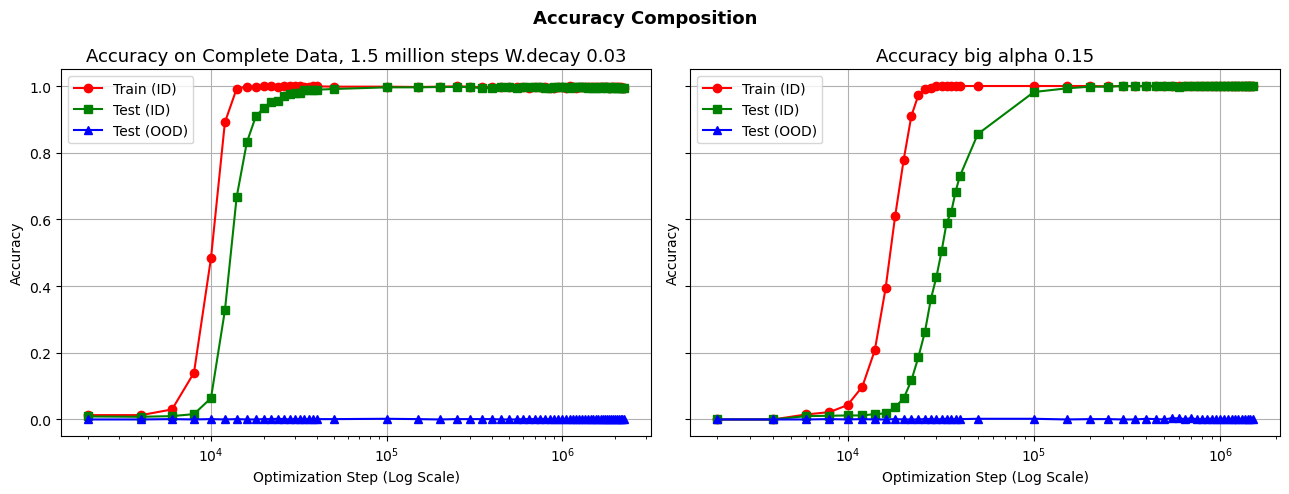

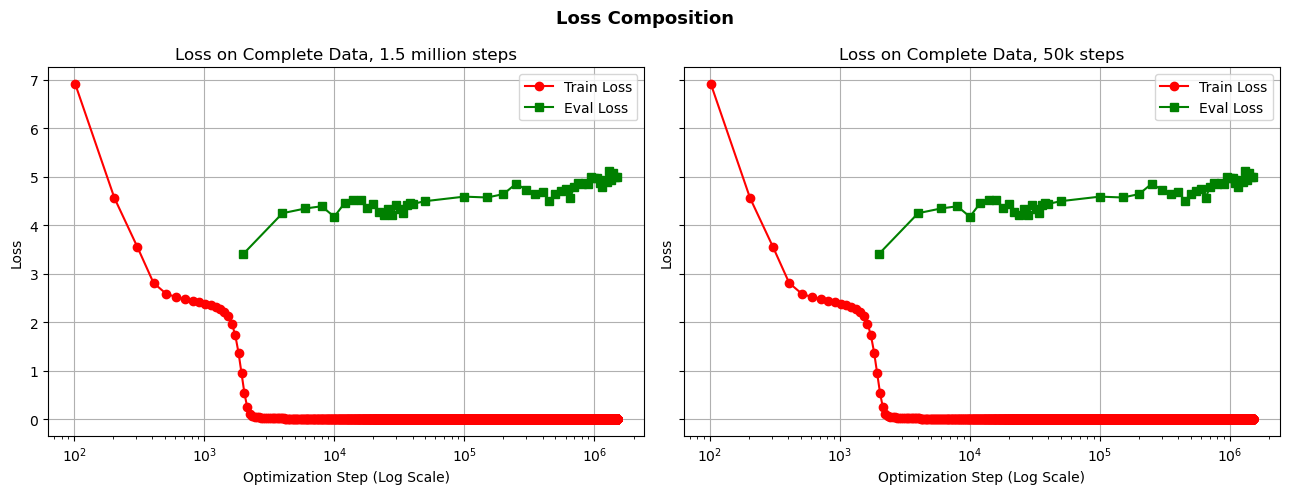

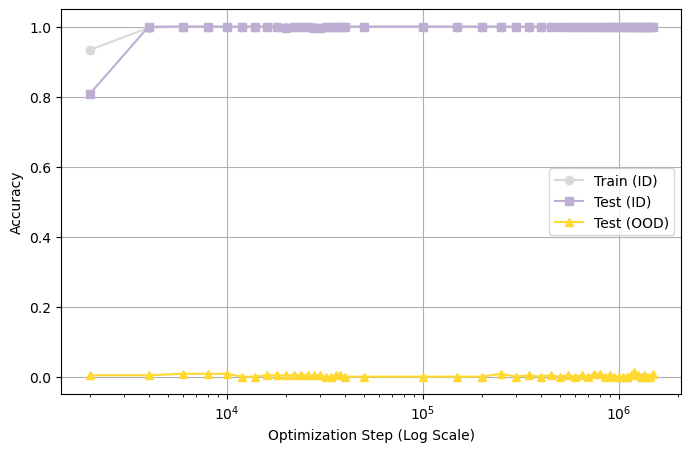

In [4]:
SMALL = "/scratch/davide/model_paper/outputs_SMALL/"
#SMALL="/dtu-compute/s220331/composition/outputs_BIG_new/"
#SMALL = "/dtu-compute/s220331/composition/model_paper/outputs_SMALL/"  # use this after moving it to the right folder

gig_alpha= "/dtu-compute/s220331/composition/outputs_BIG_alpha_0_001/"  # see if with extream small alpha somehting change more 
gig_alpha= "/dtu-compute/s220331/composition/outputs_BIG_new_alpha_0_15/"
dic_score_big_alpha = dic_scores(gig_alpha, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')


big=  "/dtu-compute/s220331/composition/outputs_BIG_extream_training/" #extream training see for improvements in ID -OOD separation t_SNE
 #"/dtu-compute/s220331/composition/outputs_BIG_new/"
dic_score_big = dic_scores(big, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

dic_score_SMALL = dic_scores(SMALL, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

Acc_graph(dic_score_big , dic_score_big_alpha ,title_1 = 'Accuracy on Complete Data, 1.5 million steps W.decay 0.03'  , title_2 = "Accuracy big alpha 0.15",compare_scale=False)
Loss_graph_1(SMALL , SMALL,title_1 = 'Loss on Complete Data, 1.5 million steps'  , title_2 = "Loss on Complete Data, 50k steps")

Acc_1( dic_score_SMALL)    

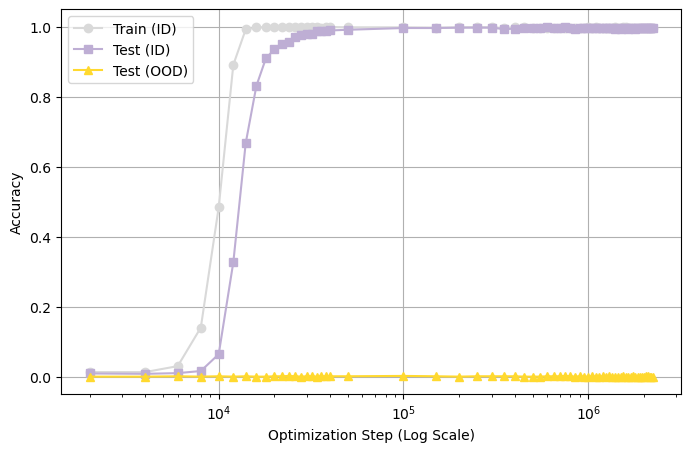

In [5]:
Acc_1(dic_score_big )

## Weight Decay INCREASE  (0.8 ; 1,5)

sharing_big = "/scratch/davide/model_paper/outputs_sharing_2000_200_12_6/"

small = "/scratch/davide/model_paper/outputs_SMALL/"

sharing_SMALL ="/scratch/davide/model_paper/outputs_SMALL_sharing/"


# **Sharing LORO**  
**prima di split ed anche di DATA_mio  é "data" semplice se devi usare i dati per qualcosa !!!**
**  Knowledg-sharing  loro spiagazione**


This is implemented in *transformers/src/transformers/models/gpt2/modeling_gpt2.py* where the layers are simply run twice when *config.add_recurrence* is True.

>        if add_recurrence:
>            recur_step = 2
>        else:
>            recur_step = 1

For this reason dor running we have:

**--n_layer 4** and **--add_recurrence** flag


**Critic:**
Basically they let the model perform **OOD** 2-hop by designing the model architecture to achive the precise task.

In fact, it has been seen that the model is able to memorize/learn all the Atomic facts (1-hop). From that, it follows that if the 2-hop task is splitted as two 1-hop tasks that will be porocesed separately and succesively from the model, 100% accuracy for the OOD task would be acjived.

    *(More in detail, this would be implemented by splitting the 2_hop task in two 1-hop tasks which were performed in two successive inference calls (first A-r_1 -->B);Then, take the result "B" as input of a second inference call  (B-r_2 -->C) , the model will be able to achive the described 2-hop task.)*

However, this method that somehow reseble a "separate call of a chain of though"is adding an external knowledge and constrain to the model design. More precisely, that the connection A,r_1,2_2--> C is acceptable logical conncection or more generally that the model given the input state "B" does not need to take in consideration the previous states that brought to arrive there. In facts, by splitting the 2-hop in two one hop recursive task we are implementing this additional model constrain by design. 

In the article, they decided to implement their *Knowledge_sharig* model buy resembling the above cited mechanism, and implementing it directl inside in the model. Basically, what they did is to train on 4 layers and calvulate it recurrently (With or without forgetting from where B came?? check in *transformers/src/transformers/models/gpt2/modeling_gpt2.py*  and search for recur_step  understand the forward what is doing )



**Suppositions**
In addition, 



Experiment: 
1) once the sharing_SMALL get to 100%accuracy (or similar)  we can use the model to do an experiment. More precisely we can test for 3-hops.  (Hyp:  fails ---- tested **YES FAILS**)

2) **training on 3-Hops** dataset with same architecure 2 recurrences (hyp : fails ---- tested **YES FAILS**)  )

3) **training on 3-Hops** dataset with **3** recurrences (hyp : fails ---- tested **YES FAILS**)  )

3)Training the normal model on **"2-hops splitted dataset"**  (hyp: 100% accuracy on 2 hops)  
    3.1) Using the ormal model on **"2-hops splitted dataset"**  and test on 3 -hop as in 1)  (hyp: Achive)

**Sharing loro normal**

  0%|          | 0/51 [00:00<?, ?it/s]

100%|██████████| 51/51 [00:01<00:00, 40.60it/s]


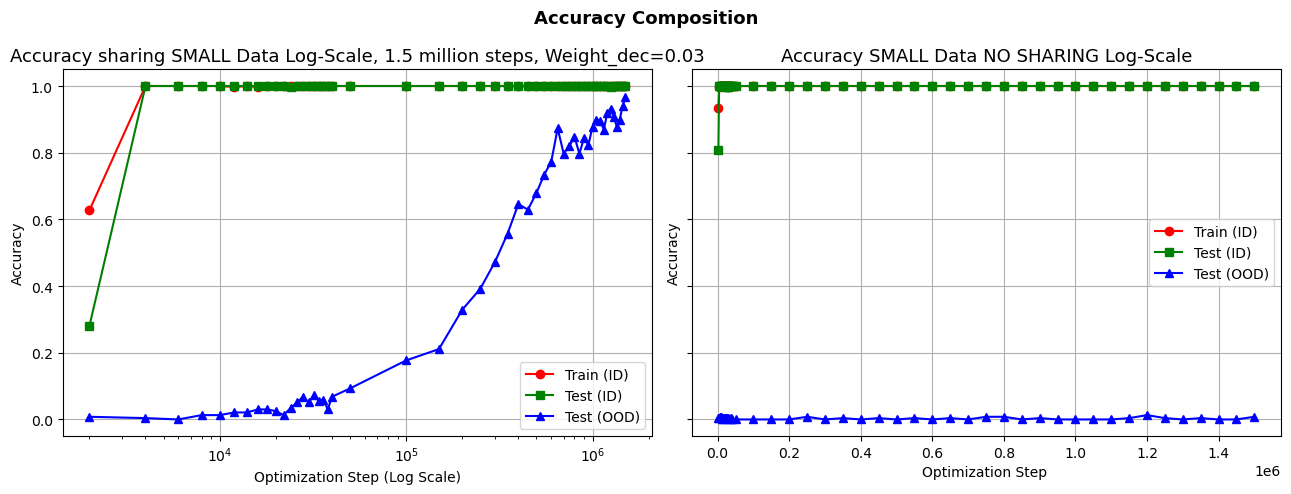

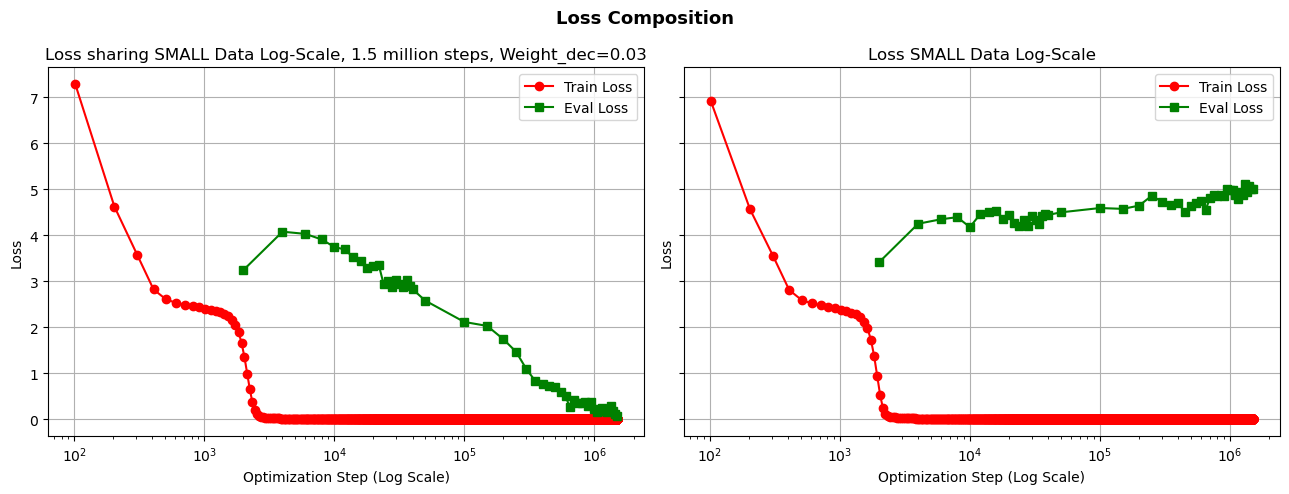

In [7]:
#sharing_SMALL ="/scratch/davide/model_paper/outputs_SMALL_sharing/"
sharing_SMALL ="/dtu-compute/s220331/composition/model_paper/outputs_SMALL_sharing/"

dic_score_sharing_SMALL = dic_scores(sharing_SMALL, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

Acc_graph(dic_score_sharing_SMALL , dic_score_SMALL ,title_1 = 'Accuracy sharing SMALL Data Log-Scale, 1.5 million steps, Weight_dec=0.03'  , title_2 = "Accuracy SMALL Data NO SHARING Log-Scale",compare_scale=True)
Loss_graph_1(sharing_SMALL , SMALL,title_1 = 'Loss sharing SMALL Data Log-Scale, 1.5 million steps, Weight_dec=0.03'  , title_2 = "Loss SMALL Data Log-Scale")

 **sharing Small Batch **  25  vs bach 128 (destra)**

Interestingly it seems that same configuration with batch 25 *4 (=100) instead of 128 *4 ( 500 and something) not open up to OOD geenralization in sharing setting

100%|██████████| 51/51 [00:01<00:00, 41.38it/s]


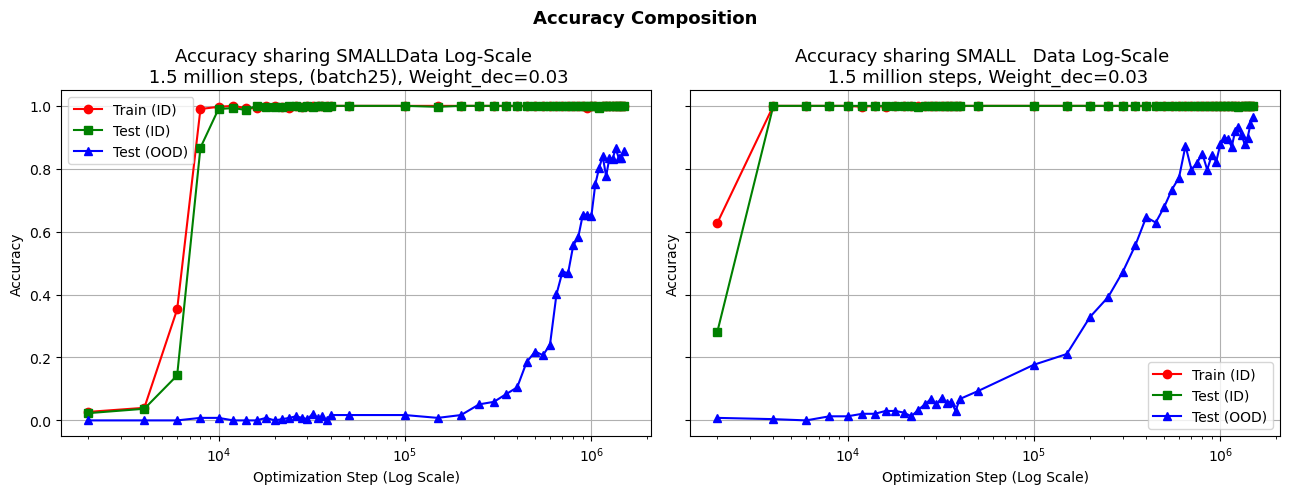

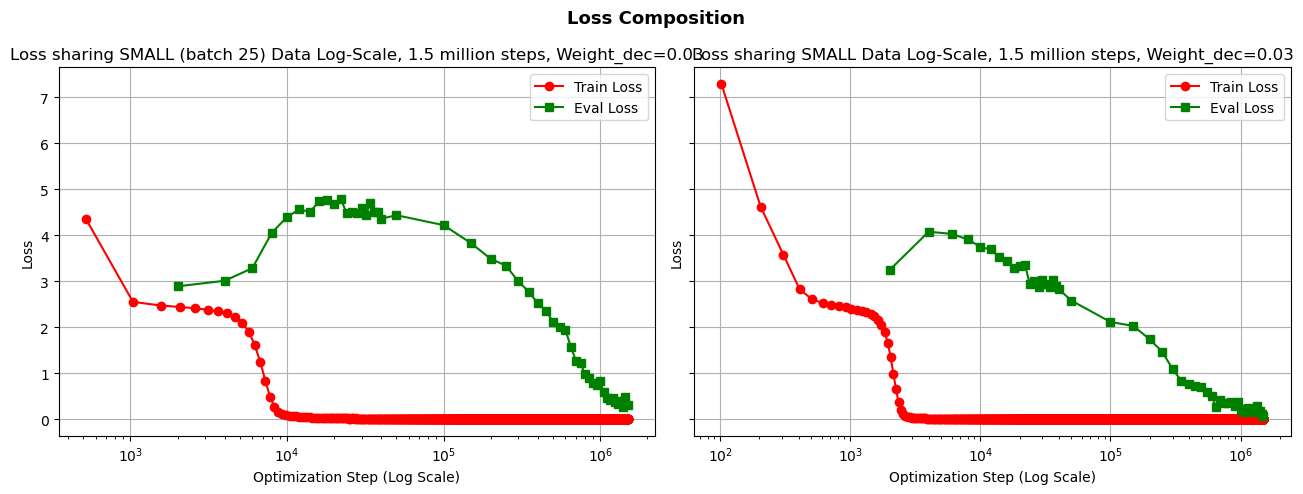

In [8]:
#sharing_SMALL_batch_25 = "/scratch/davide/model_paper/outputs_SMALL_sharing_batch_25/"
sharing_SMALL_batch_25 = "/dtu-compute/s220331/composition/model_paper/outputs_SMALL_sharing_batch_25/"
dic_score_sharing_SMALL_batch_25 = dic_scores(sharing_SMALL_batch_25, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

Acc_graph(dic_score_sharing_SMALL_batch_25 , dic_score_sharing_SMALL ,title_1 = 'Accuracy sharing SMALLData Log-Scale \n 1.5 million steps, (batch25), Weight_dec=0.03'  , title_2 = 'Accuracy sharing SMALL   Data Log-Scale \n 1.5 million steps, Weight_dec=0.03',compare_scale=False)
Loss_graph_1(sharing_SMALL_batch_25 , sharing_SMALL, title_1 = 'Loss sharing SMALL (batch 25) Data Log-Scale, 1.5 million steps, Weight_dec=0.03'  , title_2 = 'Loss sharing SMALL Data Log-Scale, 1.5 million steps, Weight_dec=0.03')

It could be noticed that lowering down the batch size too much is actually affecting/ delaying the model generalization ability . (Why? Reflect on that)

### SHARING with re mebed

100%|██████████| 51/51 [00:03<00:00, 13.04it/s]


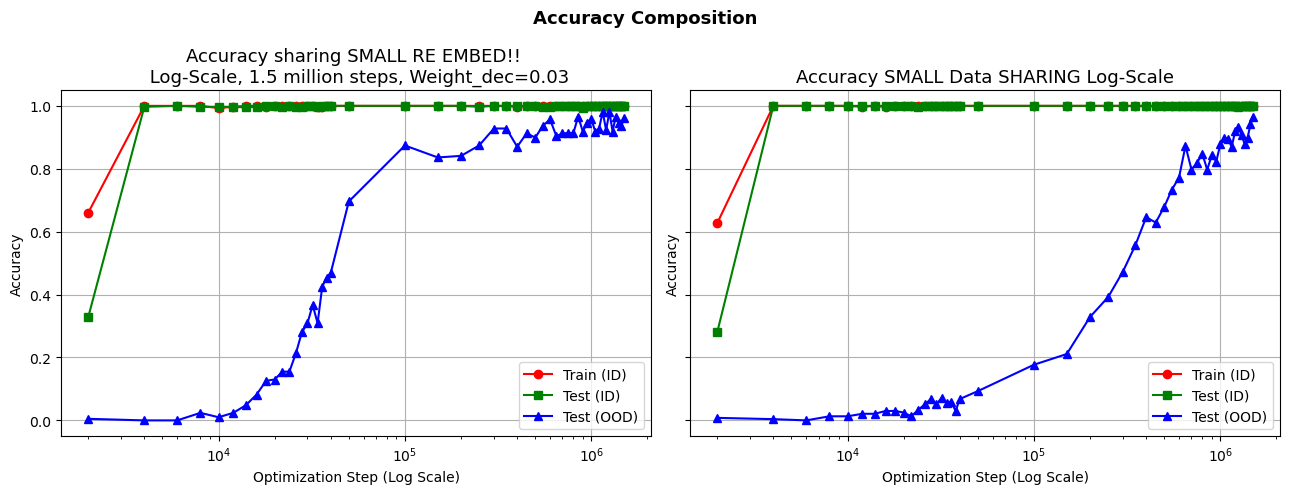

In [9]:


sharing_SMALL_RE_EMB ="/dtu-compute/s220331/composition/re_embed_sharing/"

dic_score_sharing_SMALL_RE_EMB = dic_scores(sharing_SMALL_RE_EMB, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

Acc_graph(dic_score_sharing_SMALL_RE_EMB ,dic_score_sharing_SMALL ,title_1 = 'Accuracy sharing SMALL RE EMBED!! \n Log-Scale, 1.5 million steps, Weight_dec=0.03'  , title_2 = "Accuracy SMALL Data SHARING Log-Scale",compare_scale= False)
#Loss_graph_1(sharing_SMALL , SMALL,title_1 = 'Loss sharing SMALL Data Log-Scale, 1.5 million steps, Weight_dec=0.03'  , title_2 = "Loss SMALL Data Log-Scale")

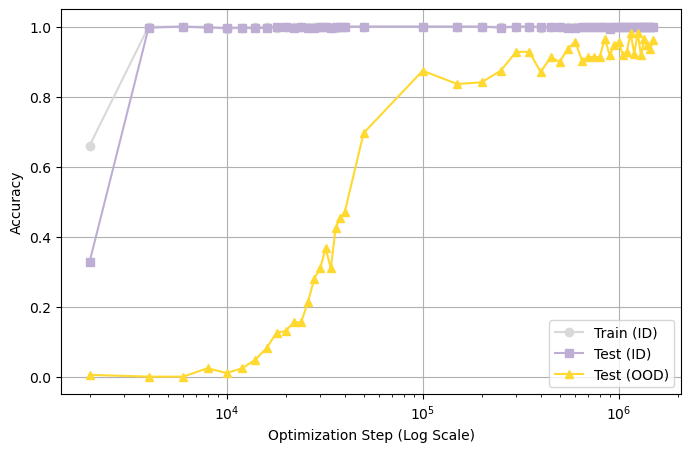

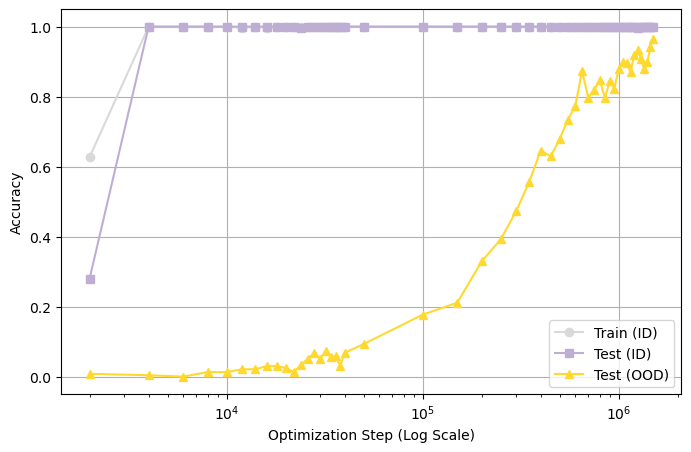

In [10]:
Acc_1(dic_score_sharing_SMALL_RE_EMB)
Acc_1(dic_score_sharing_SMALL)

# sharing big wit re embed

  0%|          | 0/51 [00:00<?, ?it/s]

100%|██████████| 51/51 [00:05<00:00,  8.62it/s]


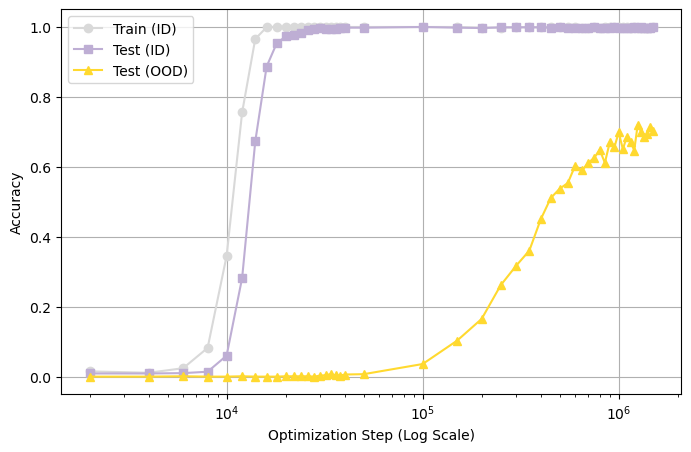

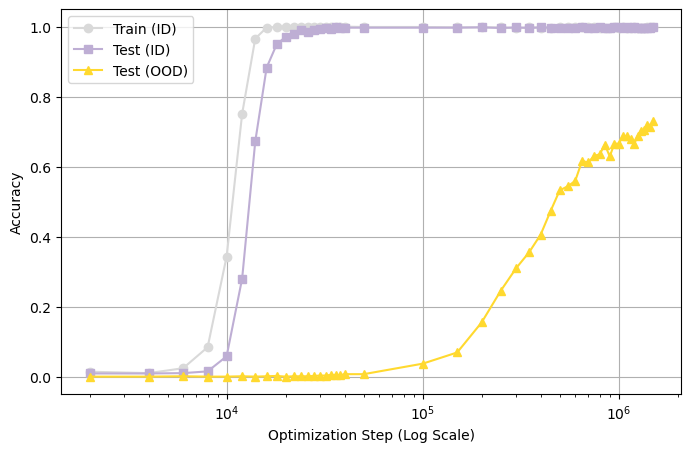

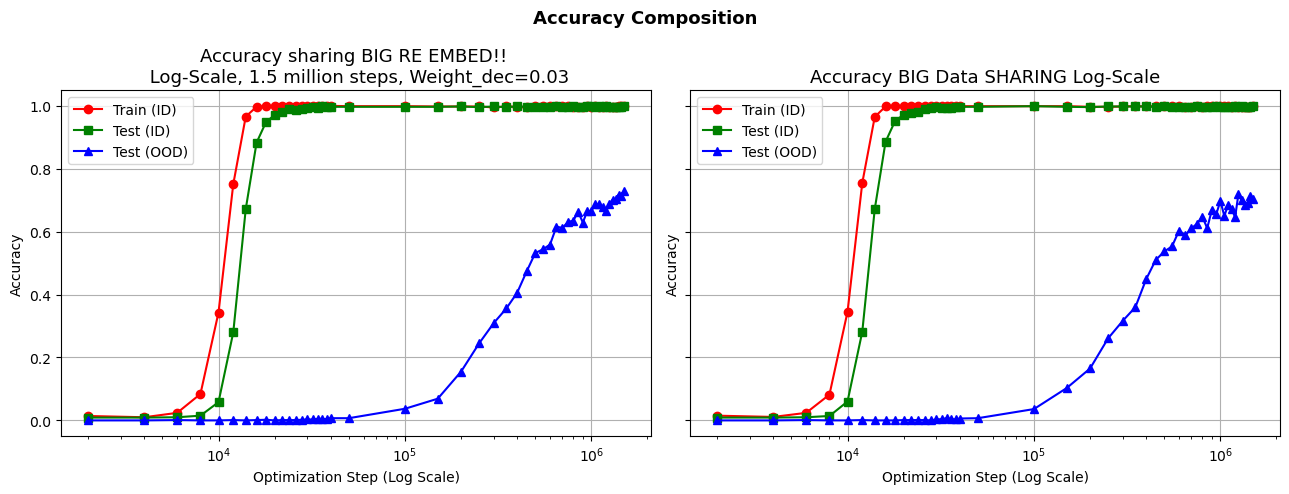

In [11]:
sharing_bigL_RE_EMB="/dtu-compute/s220331/composition/sharing_BIG_re_embed_WD_0_03/"
dic_score_sharing_bigL_RE_EMB = dic_scores(sharing_bigL_RE_EMB, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

sharing_bigL_RE_EMB_0_3="/dtu-compute/s220331/composition/sharing_BIG_re_embedding/"
dic_score_sharing_bigL_RE_EMB_0_3 = dic_scores(sharing_bigL_RE_EMB_0_3, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')


sharing_big ="/dtu-compute/s220331/composition/sharing_BIG/"
dic_score_sharing_big = dic_scores(sharing_big, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

Acc_1(dic_score_sharing_big )
Acc_1(dic_score_sharing_bigL_RE_EMB_0_3)
Acc_graph(dic_score_sharing_bigL_RE_EMB_0_3 ,dic_score_sharing_big ,title_1 = 'Accuracy sharing BIG RE EMBED!! \n Log-Scale, 1.5 million steps, Weight_dec=0.03'  , title_2 = "Accuracy BIG Data SHARING Log-Scale",compare_scale= False)

Is interesting to notice how doing the re embedding after the 1st recurrence will bring the model to generalize faster. This could be explained as the model after the first reccurrence (4layer) somehow regularize the data to fit on the embedding space = extracting the features of interest getting rid of some feture noise

# **3 hop**

A= sharing batch 25
B = sharing normal batch 128

## **Normal**   3 hop 

Your observation aligns with principles in mathematics and deep learning that describe how the **complexity of compositional tasks grows non-linearly** when adding additional operations, such as in multi-hop reasoning. Let’s dive into why your model struggles with the 3-hop task, supported by theoretical and empirical studies. (cite Autoregressive Large Language Models are Computationally Universal  credo sia buono vedi meglio però)

ALso, this well fit the literature for which LLM are not good in planning, as they try to encode all the knowledge in the next layers, however sometimes it does not really make sense to remember everything in working memory. Eg gioco ricordare tutuu gli oggetti detti in precedenza, ad una certa non riusciamo se non facciamo una storia che ci permette di 

---

 **1. Nonlinear Scaling of Task Complexity**
The jump from 2-hop to 3-hop reasoning increases the **combinatorial complexity** of the problem significantly, due to the following:

 **Exponential Growth in Search Space**
For each additional hop:
- The number of possible intermediate entities grows exponentially, especially if multiple relations (`r`) and entities (`b`, `c`, `d`) are possible.
- At 2 hops, the model needs to infer one intermediate entity (`b`) to connect `a` to `c` via `r` and `r_2`. At 3 hops, it must handle two intermediate steps, `b` and `c`, which requires searching a larger space.

Mathematically, this can be represented as:
\[
\text{Complexity} \sim O(E \cdot R^{n-1})
\]
Where:
- \( E \): Number of entities.
- \( R \): Number of relations.
- \( n \): Number of hops.

Even a small increase in \( n \) results in significant growth in complexity, making it harder for the model to learn the task effectively.

 **Studies Supporting Nonlinear Growth**
1. **Compositional Generalization and Reasoning**  
   Research like the one from **Keysers et al. (2019)** on the Compositional Generalization Benchmark highlights that tasks requiring multi-step reasoning exhibit **nonlinear difficulty increases** with additional steps, even for state-of-the-art transformers.

2. **Depth of Reasoning and Expressiveness**  
   Studies such as **Zaheer et al. (2020)** (BigBird) and **Vaswani et al. (2017)** (Attention is All You Need) indicate that transformer models are not inherently structured to perform hierarchical reasoning effectively without sufficient depth or architectural modifications.

3. **Mathematical Complexity in Neural Networks**  
   Work on **computational complexity in neural networks** shows that tasks like multi-hop reasoning are akin to solving multi-variable recurrence relations, which scale exponentially with added variables or "hops."  
   See: **Saxe et al. (2014)** on learning dynamics and scaling laws.

---

**2. Layer Requirements and Depth**
 **Layer Representation**
In transformers:
- Lower layers typically encode **local and syntactic patterns**.
- Intermediate layers focus on **entity linking and basic reasoning** (e.g., finding `b` in layer 4 for 2-hop tasks).
- Higher layers are tasked with **global reasoning** across all input and intermediate states.

For a 3-hop task:
- Reasoning needs to propagate through at least **3 intermediate representations (`b`, `c`, and `d`)**.
- This propagation inherently requires **more depth** for effective gradient flow and attention span. With only 12 layers, the model likely cannot represent all intermediate states effectively, especially if intermediate outputs (`b` and `c`) are not supervised.

**Empirical Scaling Laws**
Scaling laws in transformers, as discussed in **Kaplan et al. (2020)**, show that deeper models perform better for tasks with higher complexity, as they allow:
1. Greater **contextual representation**.
2. Enhanced **capacity for iterative reasoning**.

For example:
- A 2-hop task typically requires 8 layers because finding `b` and propagating information to `c` fits within that depth.
- A 3-hop task might require 16–24 layers to accommodate both the increased reasoning steps and to prevent over-squashing of intermediate representations.

---

**3. Recommendations**
 **How Many Layers Are Needed?**
1. **Empirical Testing**  
   Studies show that the required depth grows linearly (or super-linearly) with the number of hops in reasoning tasks:
   \[
   \text{Number of Layers} \propto \text{Hops}^k, \quad k \geq 1
   \]
   - For 2-hop tasks: \( \sim 8 \) layers suffice.
   - For 3-hop tasks: \( 16–24 \) layers may be necessary.

2. **Memory-Augmented Models**  
   Incorporate a **memory mechanism** to store intermediate entities (`b`, `c`) explicitly. This reduces the burden on depth alone to propagate intermediate representations. See approaches like **Transformer-XL** or **Compositional Memory Networks**.

3. **Supervision on Intermediate Representations**  
   Supervise the prediction of intermediate entities (`b`, `c`) during training to help the model learn multi-step reasoning more effectively.

---

 **4. Supporting Studies**
Here are some relevant references for further reading:
- **Kaplan et al. (2020)**: Scaling Laws for Neural Language Models.
- **Keysers et al. (2019)**: Measuring Compositional Generalization: A Comprehensive Method on Realistic Data.
- **Vaswani et al. (2017)**: Attention Is All You Need.
- **Zaheer et al. (2020)**: Big Bird: Transformers for Longer Sequences.
- **Saxe et al. (2014)**: Exact solutions to the nonlinear dynamics of learning in deep linear neural networks.

These studies outline the challenges of scaling transformer models for tasks requiring multi-step reasoning and the necessity of deeper architectures or novel mechanisms like memory.

--- 

 **Conclusion**
Your observation of the 12-layer GPT-2 struggling with 3-hop reasoning is expected due to the non-linear scaling of task complexity. Increasing depth to 16–24 layers or using memory-augmented transformers should improve performance. Additionally, supervising intermediate steps can further help the model manage reasoning over longer chains effectively.

100%|██████████| 47/47 [00:00<00:00, 48.57it/s]


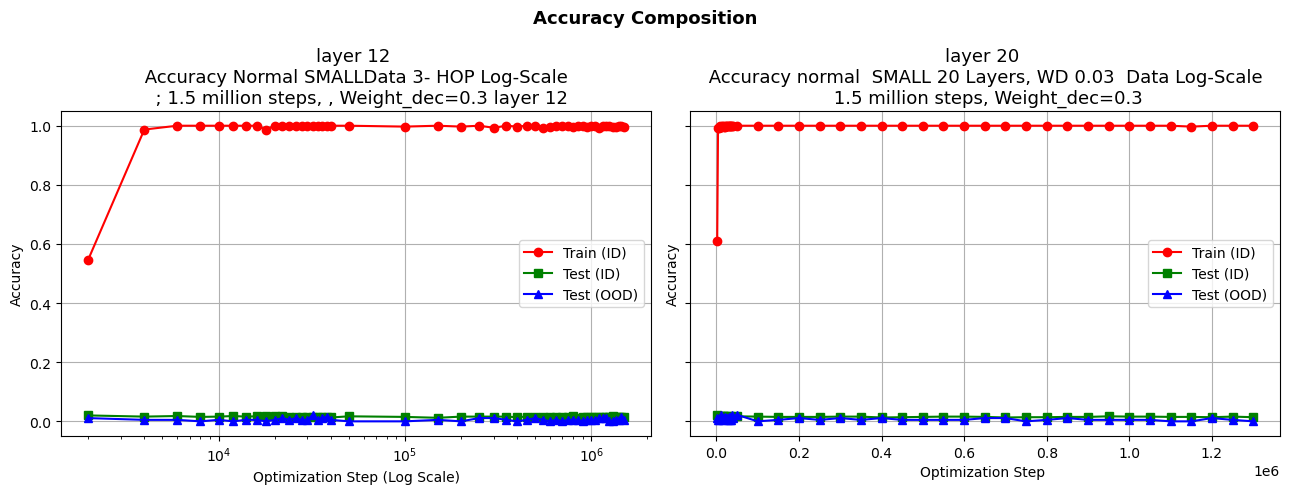

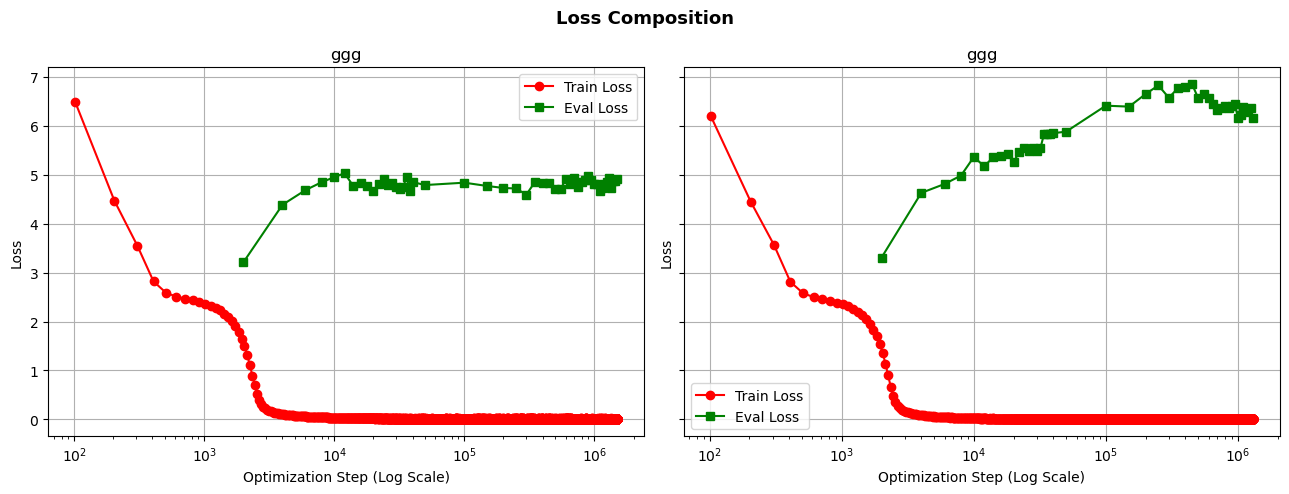

In [12]:
# 3_HOP SMALL  , normal Batch 128    
#normal_SMALL_HOP_3_LAYER_12= "/scratch/davide/model_paper/outputs_SMALL_3HOP_normal_12_layer/"
normal_SMALL_HOP_3_LAYER_12= "/dtu-compute/s220331/composition/model_paper/outputs_SMALL_3HOP_normal_12_layer/"


dic_score_normal_SMALL_HOP_3_LAYER_12 = dic_scores(normal_SMALL_HOP_3_LAYER_12, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')


normal_SMALL_HOP_3_LAYER_20= "/scratch/davide/model_paper/outputs_SMALL_3HOP_normal_20_layer/"
dic_score_normal_SMALL_HOP_3_LAYER_20 = dic_scores(normal_SMALL_HOP_3_LAYER_20, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

Acc_graph(dic_score_normal_SMALL_HOP_3_LAYER_12, dic_score_normal_SMALL_HOP_3_LAYER_20 ,title_1 = 'layer 12 \n Accuracy Normal SMALLData 3- HOP Log-Scale \n  ; 1.5 million steps, , Weight_dec=0.3 layer 12'  , title_2 = 'layer 20 \n Accuracy normal  SMALL 20 Layers, WD 0.03  Data Log-Scale \n 1.5 million steps, Weight_dec=0.3',compare_scale=True)
Loss_graph_1(normal_SMALL_HOP_3_LAYER_12 , normal_SMALL_HOP_3_LAYER_20 , title_1 = 'ggg'  , title_2 = 'ggg')

100%|██████████| 22/22 [00:00<00:00, 293.72it/s]


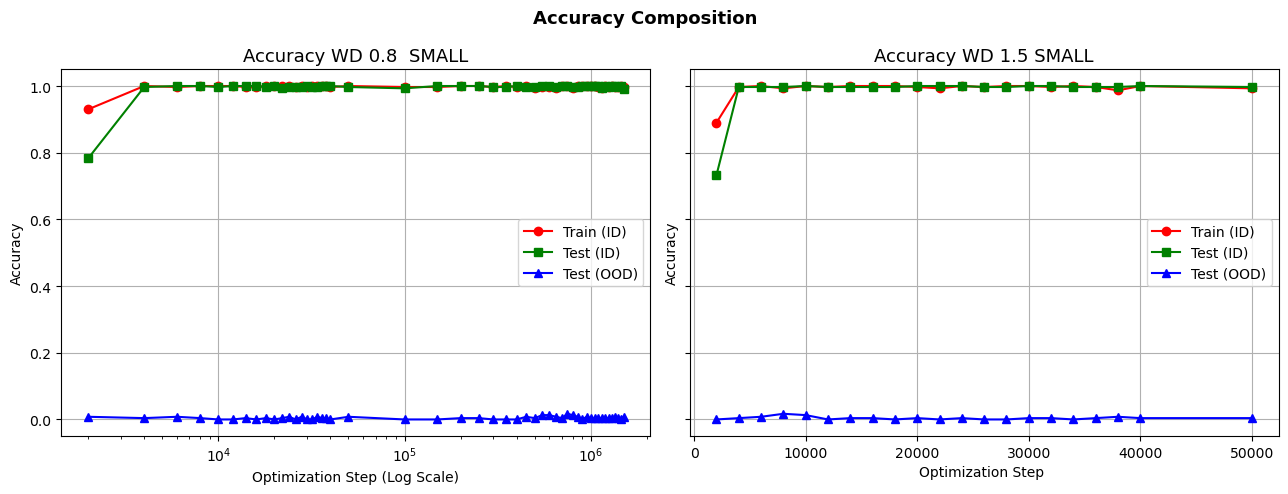

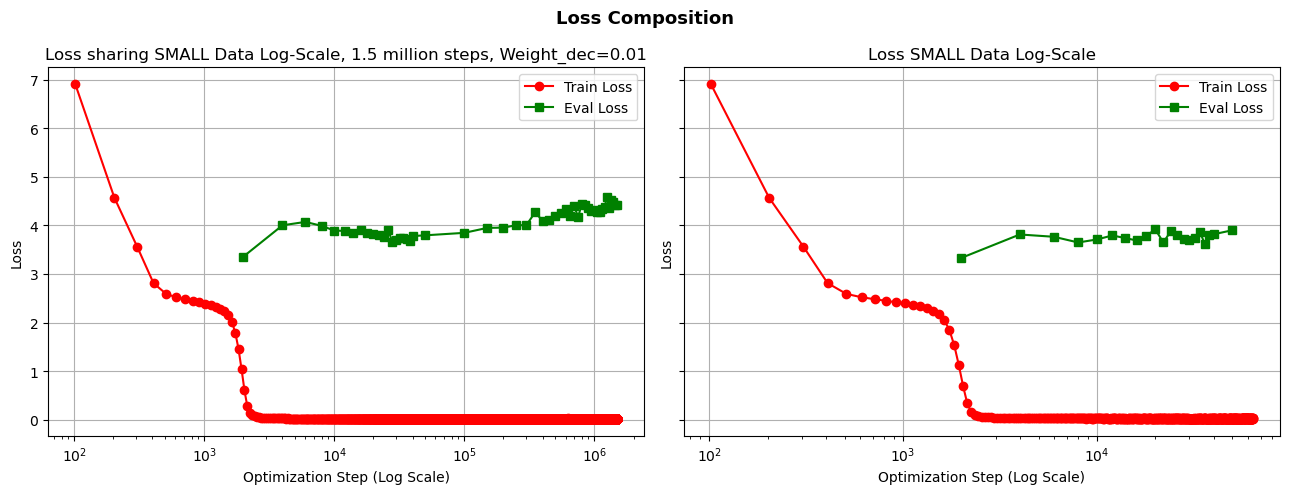

In [13]:
# Mot sure if is the the full data or small (I think small just check in scratch if you use it)
#normal_big_WD_0_8 = "/scratch/davide/model_paper/outputs_SMALL_WD_0_8/"
normal_big_WD_0_8 = "/dtu-compute/s220331/composition/model_paper/outputs_SMALL_WD_0_8/"

dic_score_normal_big_WD_0_8 = dic_scores(normal_big_WD_0_8, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

normal_big_WD_1_5 = "/scratch/davide/model_paper/outputs_SMALL_WD_0_1_5/"

dic_score_normal_big_WD_1_5 = dic_scores(normal_big_WD_1_5, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')


#Acc_graph(dic_score_sharing_big_WD_0_8  , dic_score_sharing_big_WD_0_8 ,title_1 = 'Accuracy WD 0.8  SMALL'  , title_2 = "Accuracy WD 1.5 SMALL",compare_scale=True)
Acc_graph(dic_score_normal_big_WD_0_8  , dic_score_normal_big_WD_1_5 ,title_1 = 'Accuracy WD 0.8  SMALL'  , title_2 = "Accuracy WD 1.5 SMALL",compare_scale=True)
Loss_graph_1(normal_big_WD_0_8 ,normal_big_WD_1_5 ,title_1 = 'Loss sharing SMALL Data Log-Scale, 1.5 million steps, Weight_dec=0.01'  , title_2 = "Loss SMALL Data Log-Scale")

Why it get no ID GENERALIZATION? strange. Check how is the loss defined

## **SHARING**   3-hop

100%|██████████| 51/51 [00:00<00:00, 286.45it/s]


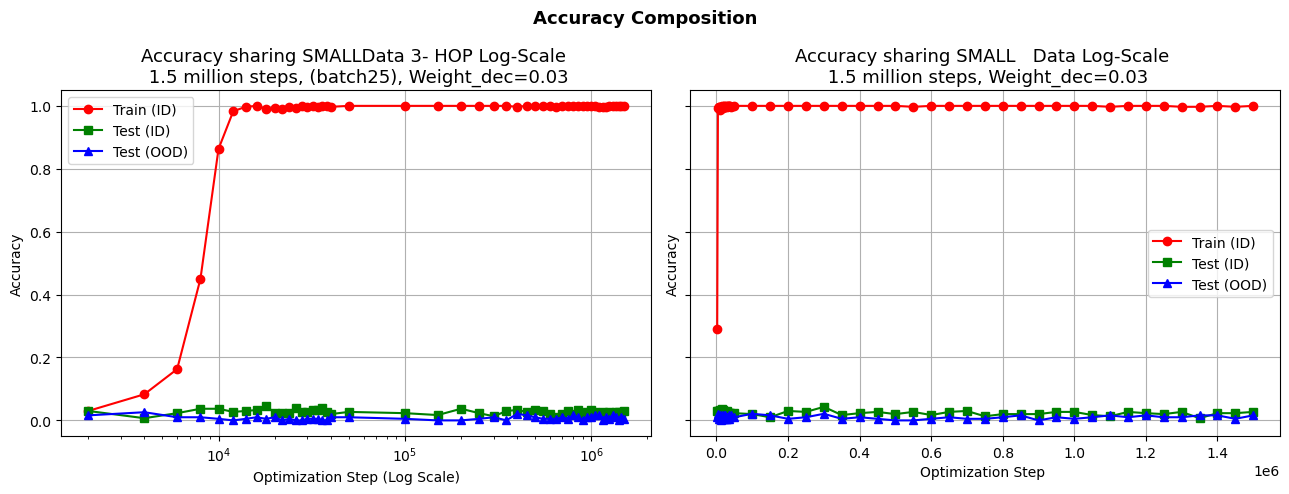

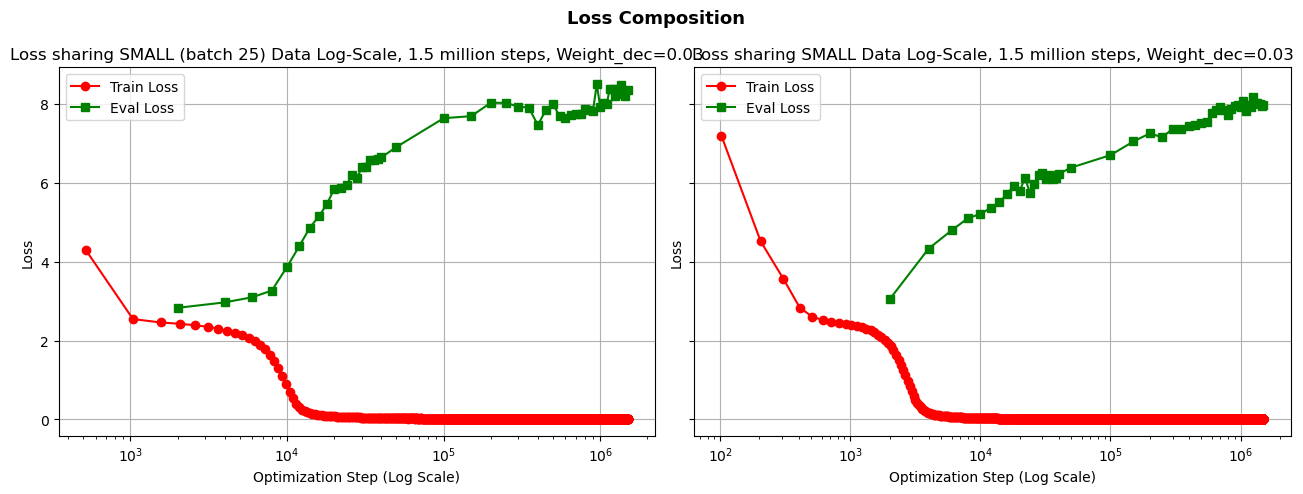

In [14]:
# 3 Hop SMALL BATCH 25
#sharing_SMALL_batch_25_HOP_3 = "/scratch/davide/model_paper/outputs_SMALL_3HOP_sharing_batch_25/"
sharing_SMALL_batch_25_HOP_3 = "/dtu-compute/s220331/composition/model_paper/outputs_SMALL_3HOP_sharing_batch_25/"

dic_score_sharing_SMALL_batch_25_HOP_3 = dic_scores(sharing_SMALL_batch_25_HOP_3, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

# 3_HOP SMALL  , normal Batch 128    
sharing_SMALL_HOP_3 = "/scratch/davide/model_paper/outputs_SMALL_3HOP_sharing/"
dic_score_sharing_SMALL_HOP_3 = dic_scores(sharing_SMALL_HOP_3, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

Acc_graph(dic_score_sharing_SMALL_batch_25_HOP_3, dic_score_sharing_SMALL_HOP_3 ,title_1 = 'Accuracy sharing SMALLData 3- HOP Log-Scale \n 1.5 million steps, (batch25), Weight_dec=0.03'  , title_2 = 'Accuracy sharing SMALL   Data Log-Scale \n 1.5 million steps, Weight_dec=0.03',compare_scale=True)
Loss_graph_1(sharing_SMALL_batch_25_HOP_3 , sharing_SMALL_HOP_3 , title_1 = 'Loss sharing SMALL (batch 25) Data Log-Scale, 1.5 million steps, Weight_dec=0.03'  , title_2 = 'Loss sharing SMALL Data Log-Scale, 1.5 million steps, Weight_dec=0.03')

Fom the graphs  it seems that the papaer "sharing" model is not able to perdorm the 3-hop generalization at all not even for ID (not expected that).

### **sharing **more Layers 6**

We can not seen any Lerning bot ID then OOD

100%|██████████| 51/51 [00:03<00:00, 15.16it/s]


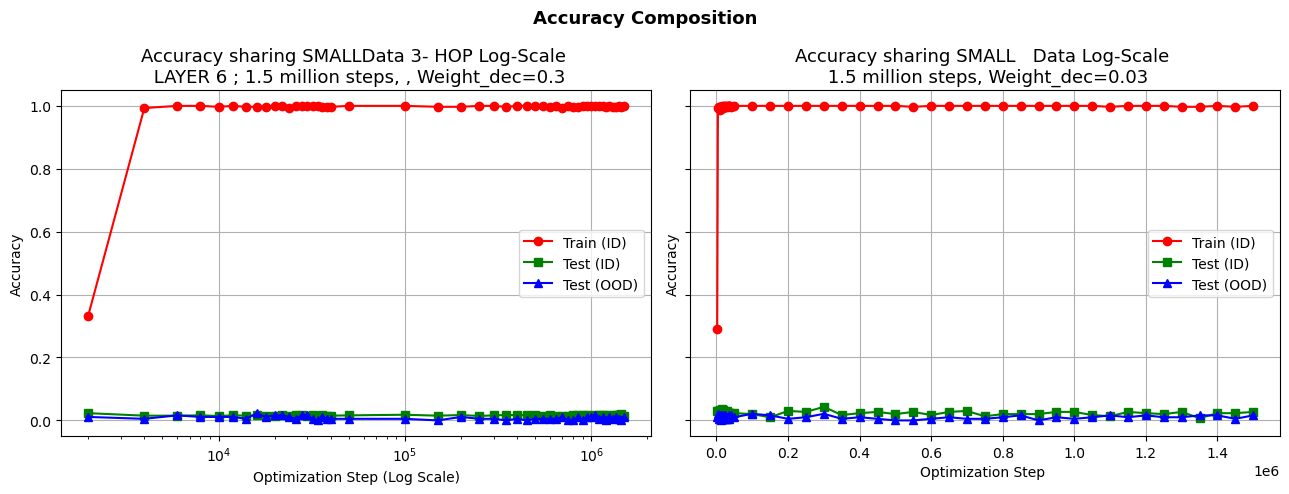

In [15]:
# 3 Hop SMALL BATCH 25

# 3_HOP SMALL  , normal Batch 128    
#sharing_SMALL_HOP_3_LAYER_6 = "/scratch/davide/model_paper/outputs_SMALL_3HOP_sharing_6_layer/"
sharing_SMALL_HOP_3_LAYER_6 = "/dtu-compute/s220331/composition/model_paper/outputs_SMALL_3HOP_sharing_6_layer/"

dic_score_sharing_SMALL_HOP_3_LAYER_6 = dic_scores(sharing_SMALL_HOP_3_LAYER_6, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

Acc_graph(dic_score_sharing_SMALL_HOP_3_LAYER_6, dic_score_sharing_SMALL_HOP_3 ,title_1 = 'Accuracy sharing SMALLData 3- HOP Log-Scale \n LAYER 6 ; 1.5 million steps, , Weight_dec=0.3'  , title_2 = 'Accuracy sharing SMALL   Data Log-Scale \n 1.5 million steps, Weight_dec=0.03',compare_scale=True)
#Loss_graph_1(sharing_SMALL_HOP_3_LAYER_6, sharing_SMALL_HOP_3 , title_1 = 'Loss sharing SMALL (batch 25) Data Log-Scale, 1.5 million steps, Weight_dec=0.03'  , title_2 = 'Loss sharing SMALL Data Log-Scale, 1.5 million steps, Weight_dec=0.03')


### **3 Recurrence model**  ( sharing loro wiht 3 instead of 2 recurrences)

Add in ag. parse _ **--recurrence_iteration_3**

>parser.add_argument("--recurrence_iteration_3", action="store_true", help="Whether run the layers twice.")


100%|██████████| 48/48 [00:03<00:00, 14.98it/s]


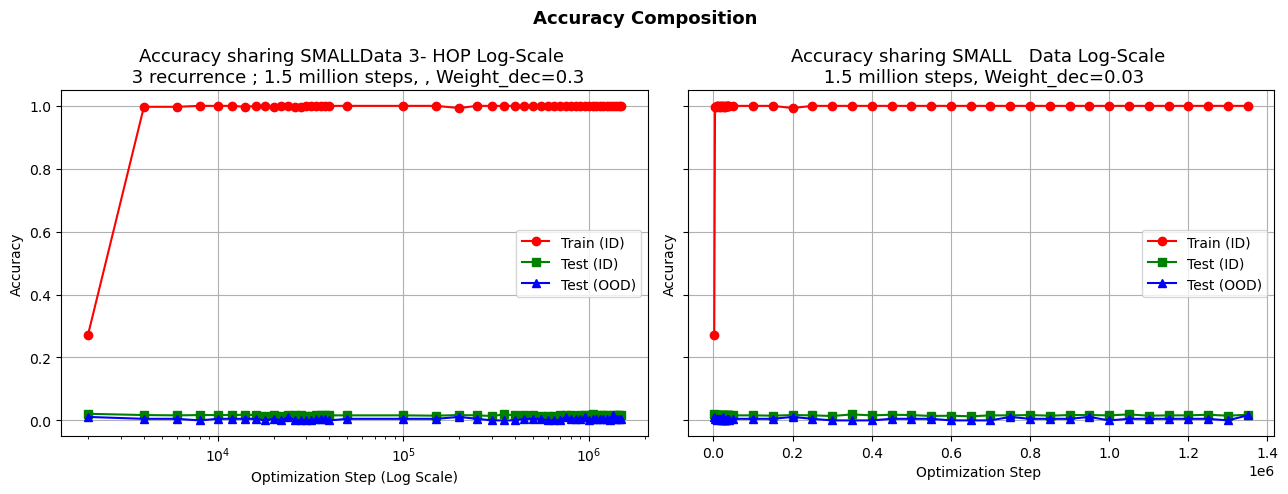

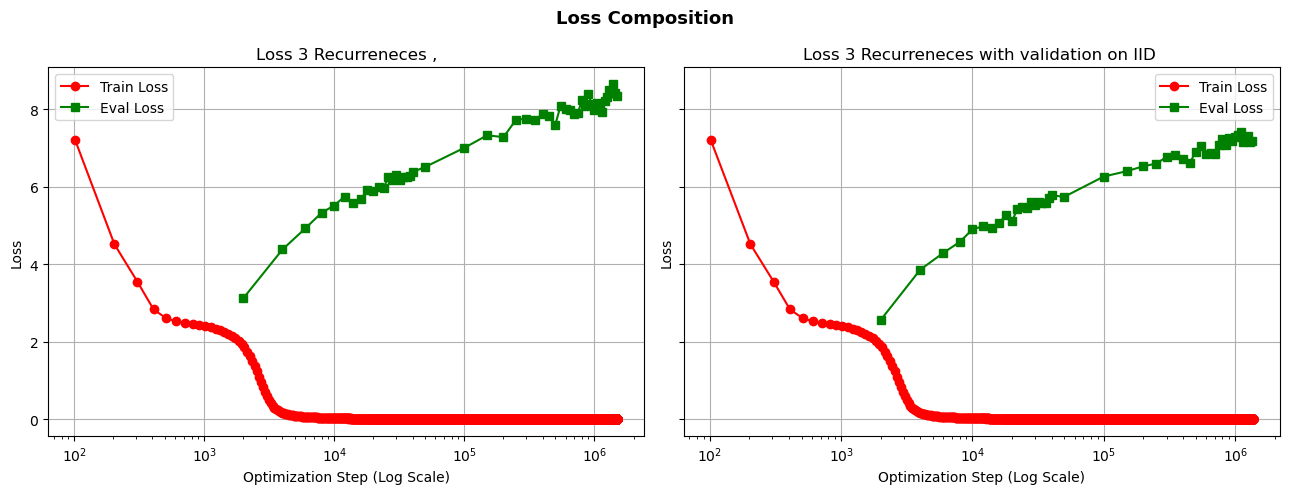

In [16]:
# 3 Hop SMALL BATCH 25

# 3 recurrences normal  
#sharing_SMALL_HOP_3_recurrence_3 = "/scratch/davide/model_paper/outputs_SMALL_3HOP_sharing_3_recurrence/"   # WD 0.03
sharing_SMALL_HOP_3_recurrence_3 = "/dtu-compute/s220331/composition/model_paper/outputs_SMALL_3HOP_sharing_3_recurrence/"   # WD 0.03

dic_score_sharing_SMALL_HOP_3_recurrence_3 = dic_scores(sharing_SMALL_HOP_3_recurrence_3, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

# 3 recurrences with eval mio IID
#sharing_SMALL_HOP_3_recurrence_3_val_IID ="/scratch/davide/model_paper/outputs_SMALL_3HOP_sharing_3_recurrence_valid_IID/"
sharing_SMALL_HOP_3_recurrence_3_val_IID ="/dtu-compute/s220331/composition/model_paper/outputs_SMALL_3HOP_sharing_3_recurrence_valid_IID/"
dic_score_sharing_SMALL_HOP_3_recurrence_3_val_IID = dic_scores(sharing_SMALL_HOP_3_recurrence_3_val_IID, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

Acc_graph(dic_score_sharing_SMALL_HOP_3_recurrence_3, dic_score_sharing_SMALL_HOP_3_recurrence_3_val_IID ,title_1 = 'Accuracy sharing SMALLData 3- HOP Log-Scale \n 3 recurrence ; 1.5 million steps, , Weight_dec=0.3'  , title_2 = 'Accuracy sharing SMALL   Data Log-Scale \n 1.5 million steps, Weight_dec=0.03',compare_scale=True)
Loss_graph_1(sharing_SMALL_HOP_3_recurrence_3, sharing_SMALL_HOP_3_recurrence_3_val_IID , title_1 = 'Loss 3 Recurreneces ,'  , title_2 = 'Loss 3 Recurreneces with validation on IID ')

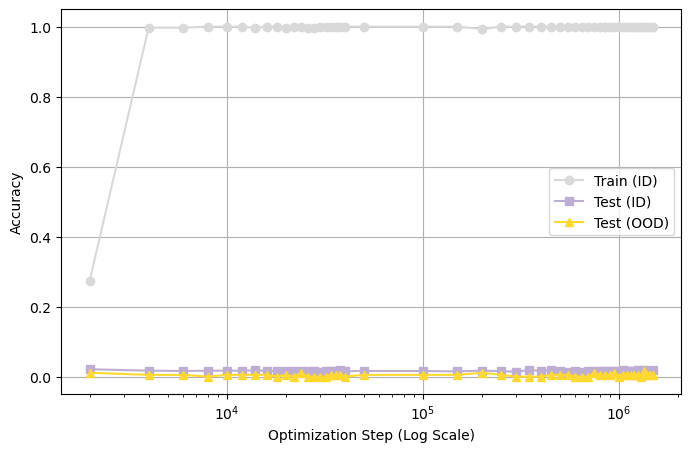

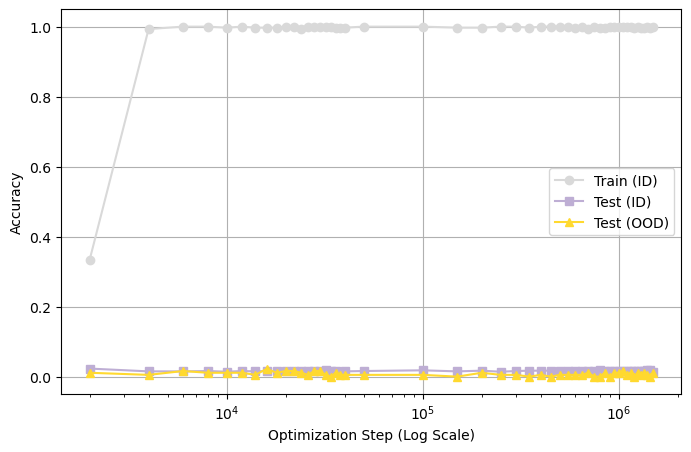

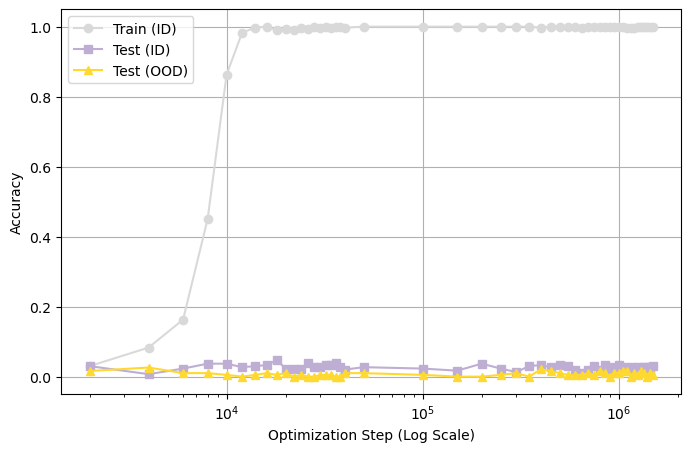

In [17]:
Acc_1(dic_score_sharing_SMALL_HOP_3_recurrence_3)
Acc_1(dic_score_sharing_SMALL_HOP_3_LAYER_6)
Acc_1(dic_score_sharing_SMALL_batch_25_HOP_3)

# **BIG (full DATA only here)**

It can be seen that tha sharing Loro is start working also on the big dataset however a smaller Weight decay slover down the process (0.01 instead of 0.03 used in the smaller case)

100%|██████████| 51/51 [00:05<00:00, 10.02it/s]


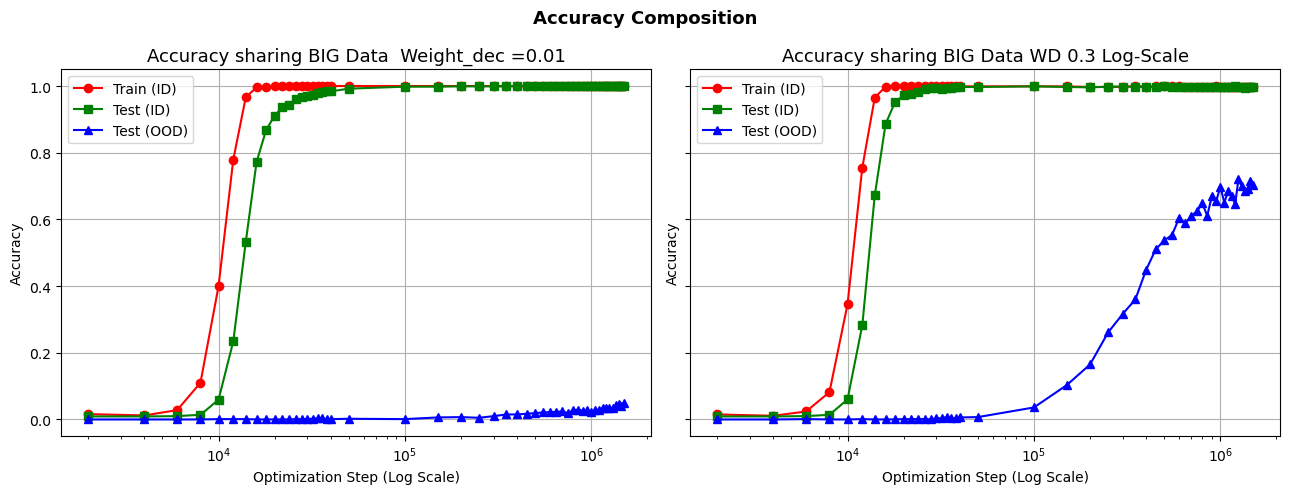

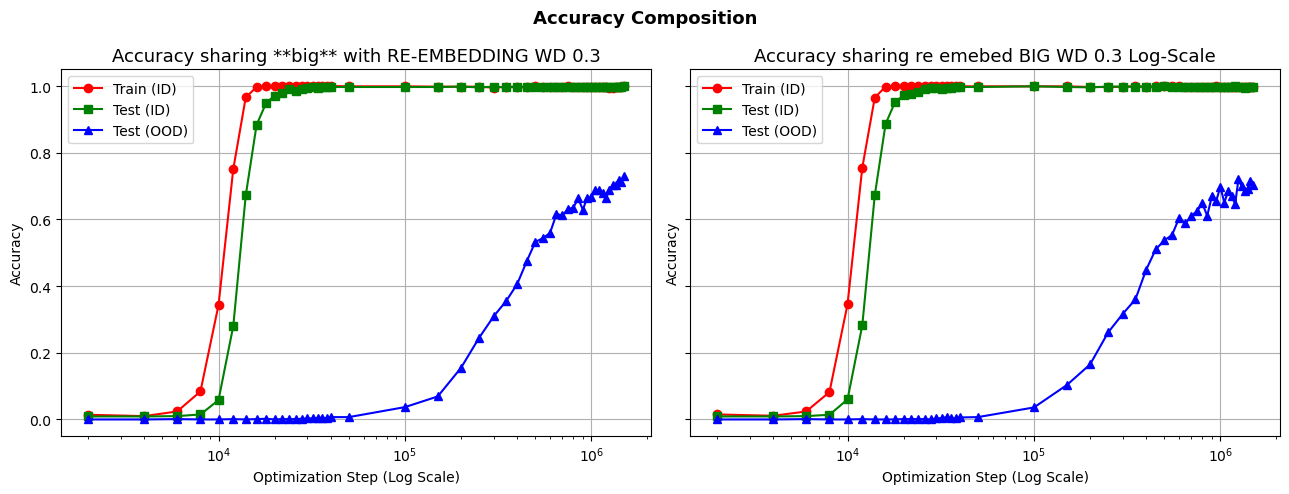

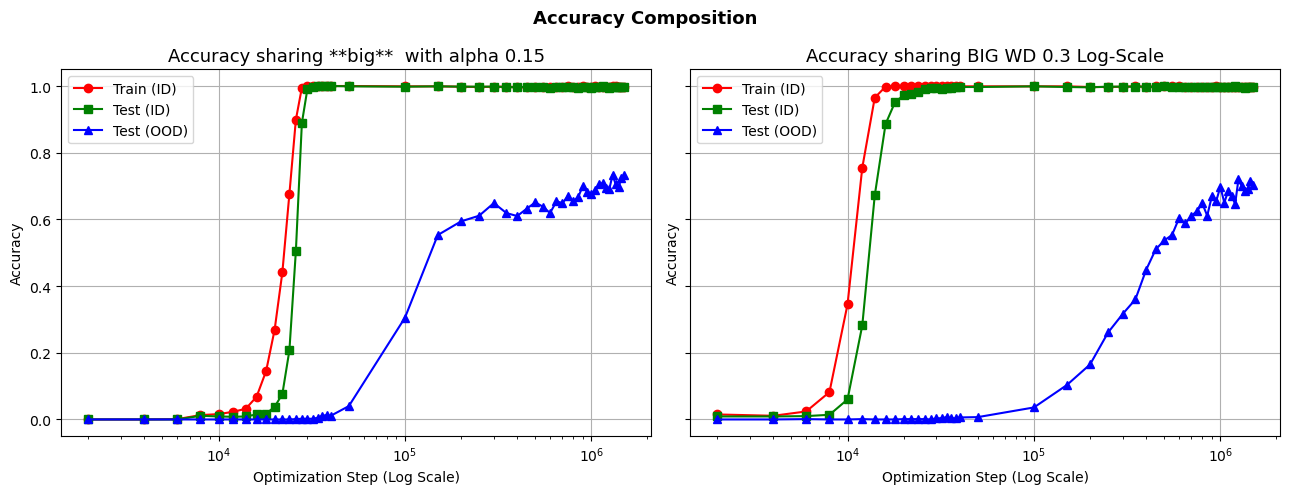

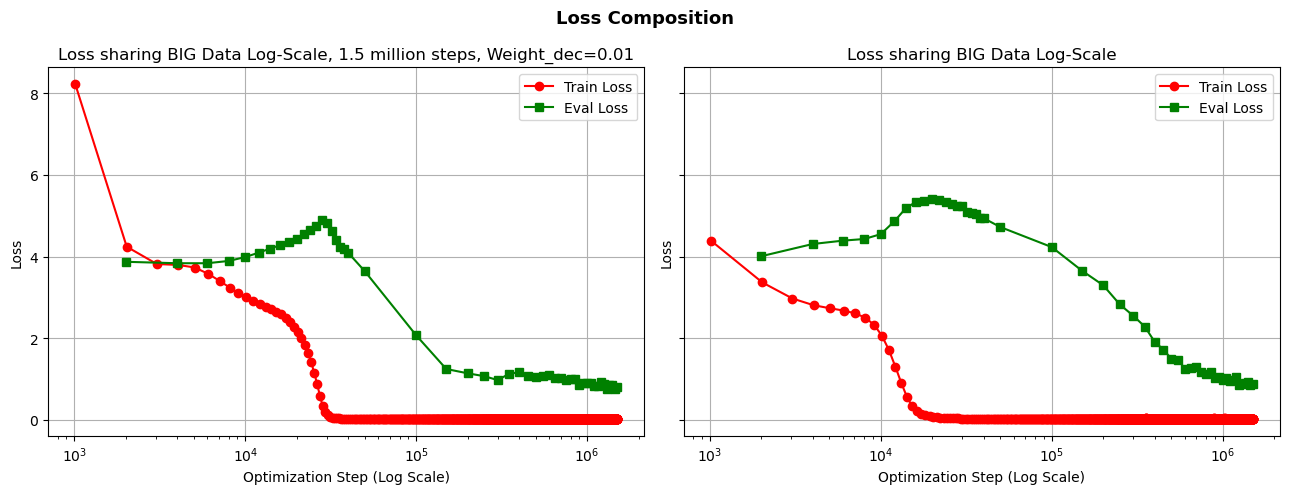

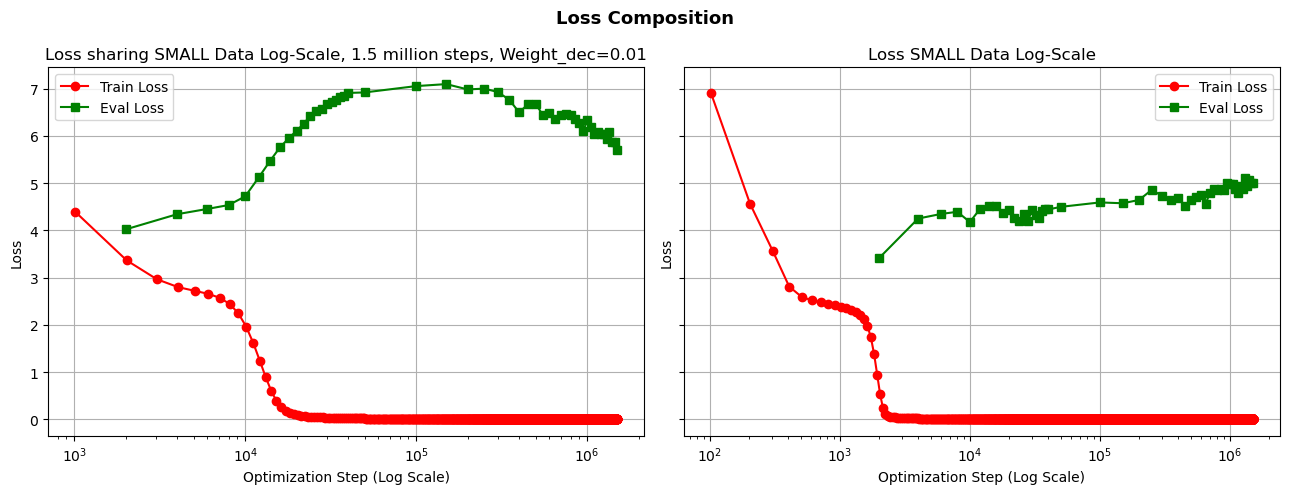

In [18]:
#sharing_big = "/scratch/davide/model_paper/outputs_sharing_2000_200_12_6/"
sharing_big = "/dtu-compute/s220331/composition/model_paper/outputs_sharing_2000_200_12_6/"

sharing_big_0_3 = "/dtu-compute/s220331/composition/sharing_BIG/"
dic_score_sharing_big_0_3 = dic_scores(sharing_big_0_3, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

# sharing big 0.03
sharing_big_0_03 ="/dtu-compute/s220331/composition/sharing_BIG_WD_0_03/"
dic_score_sharing_big_0_03 = dic_scores(sharing_big_0_03, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

# with re embedding  WD 0.3
sharing_big_RE_EMB ="/dtu-compute/s220331/composition/sharing_BIG_re_embedding/"
dic_score_sharing_big_RE_EMB = dic_scores(sharing_big_RE_EMB, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')
# re embed wd 0.03
sharing_big_0_03 ="/dtu-compute/s220331/composition/sharing_BIG_wd_0_3/"
dic_score_sharing_big_0_03 = dic_scores(sharing_big_0_3, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')


# wiht alpha 0.15
sharing_big_alpha ="/dtu-compute/s220331/composition/sharing_BIG_alpha_0_15/"
dic_score_sharing_big_alpha = dic_scores(sharing_big_alpha, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')




big="/dtu-compute/s220331/composition/outputs_BIG/"
dic_score_big = dic_scores(big, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

dic_score_sharing_big = dic_scores(sharing_big, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

Acc_graph(dic_score_sharing_big , dic_score_sharing_big_0_03 ,title_1 = 'Accuracy sharing BIG Data  Weight_dec =0.01'  , title_2 = "Accuracy sharing BIG Data WD 0.3 Log-Scale",compare_scale=False)

Acc_graph(dic_score_sharing_big_RE_EMB    , dic_score_sharing_big_0_3 ,title_1 = 'Accuracy sharing **big** with RE-EMBEDDING WD 0.3'  , title_2 = "Accuracy sharing re emebed BIG WD 0.3 Log-Scale",compare_scale=False)

Acc_graph(dic_score_sharing_big_alpha   , dic_score_sharing_big_0_3 ,title_1 = 'Accuracy sharing **big**  with alpha 0.15'  , title_2 = "Accuracy sharing BIG WD 0.3 Log-Scale",compare_scale=False)
Loss_graph_1(sharing_big_alpha , sharing_big_0_3,title_1 = 'Loss sharing BIG Data Log-Scale, 1.5 million steps, Weight_dec=0.01'  , title_2 = "Loss sharing BIG Data Log-Scale")
Loss_graph_1(sharing_big , SMALL,title_1 = 'Loss sharing SMALL Data Log-Scale, 1.5 million steps, Weight_dec=0.01'  , title_2 = "Loss SMALL Data Log-Scale")

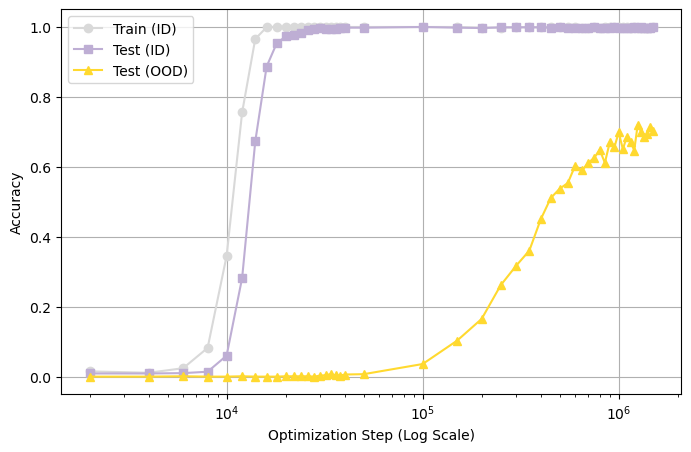

In [19]:
Acc_1(dic_score_sharing_big_0_3)

# SPLIT section  (probabily will be removed)

** My dataset with explicit split of 2 hop in two 1 hop)

(Dataset with splitted hops eg: A=B=C  with a mask)

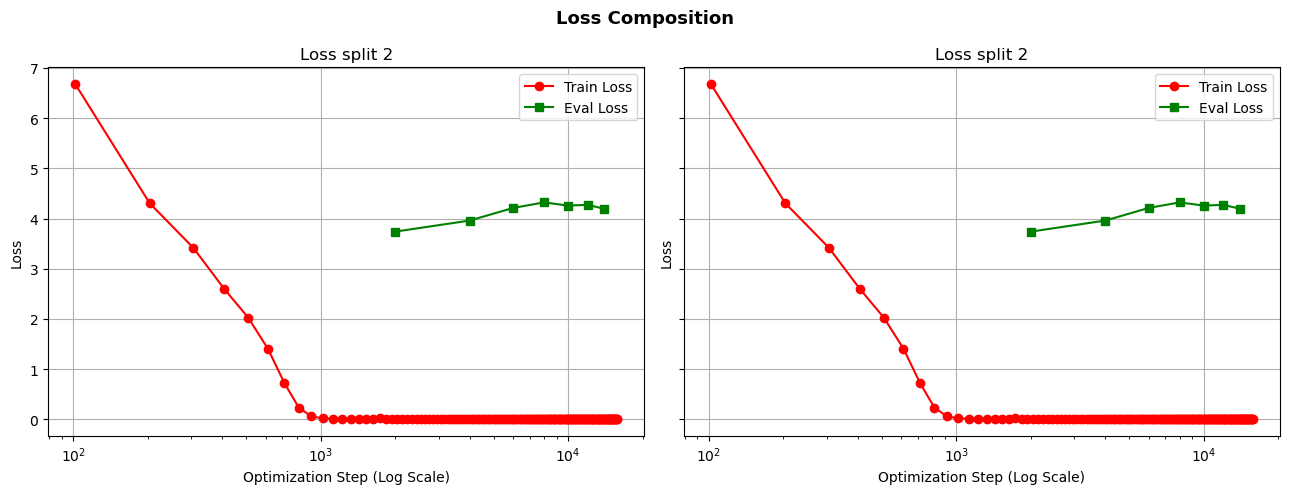

In [20]:
#split_3_SMALL = "/scratch/davide/model_paper/outputs_SMALL_split_2/"

split_2_SMALL = "/scratch/davide/model_paper/outputs_SMALL_split_2_test/"
#dic_score_split_2_small = dic_scores(split_2_SMALL , check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')
#### SPLIT 3
#split_3_SMALL = "/scratch/davide/model_paper/outputs_SMALL_split_3_HOP/"
#dic_score_split_3_small = dic_scores(split_3_SMALL , check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')



#Acc_graph(dic_score_split_2_small  , dic_score_split_2_small ,title_1 = 'Accuracy  SPLIT 2 dataset train'  , title_2 = "Accuracy SPLIT 3 HOP dataset train",compare_scale=True)

Loss_graph_1(split_2_SMALL, split_2_SMALL ,title_1 = 'Loss split 2'  , title_2 = 'Loss split 2')  # the same change the comparison when other data

# MASK_MASK

In this test we use a datatset that incluse in the training the OOD fasct seein in the 2-space hop.

1) case mask_mask :<mask>,<mask>,r_2

2) mask, B, r_2

In [21]:
#  noot used mask mask/old wrong datset
#mask_mask= "/scratch/davide/model_paper/mask_mask_0/"
#mask_B ="/scratch/davide/model_paper/mask_B_0_WD_0_3/"

**Test DATA _MIO**

Datset in which the OOD atomic were fed in the train as : <mask>,b,r,t (= <mask,atomic_ood)
The idea is that also ood Atomic are seen further in the sequence "as part of the second hop", but we do not gave actually any additional information to the model on how to combine it.

In the **ID** case we put also some ID atomic with the same new (= <mask,atomic) configuration to help the model to connect the infromation. Hyp: helps to geenralize faster (but maybe not).

100%|██████████| 37/37 [00:00<00:00, 39.60it/s]


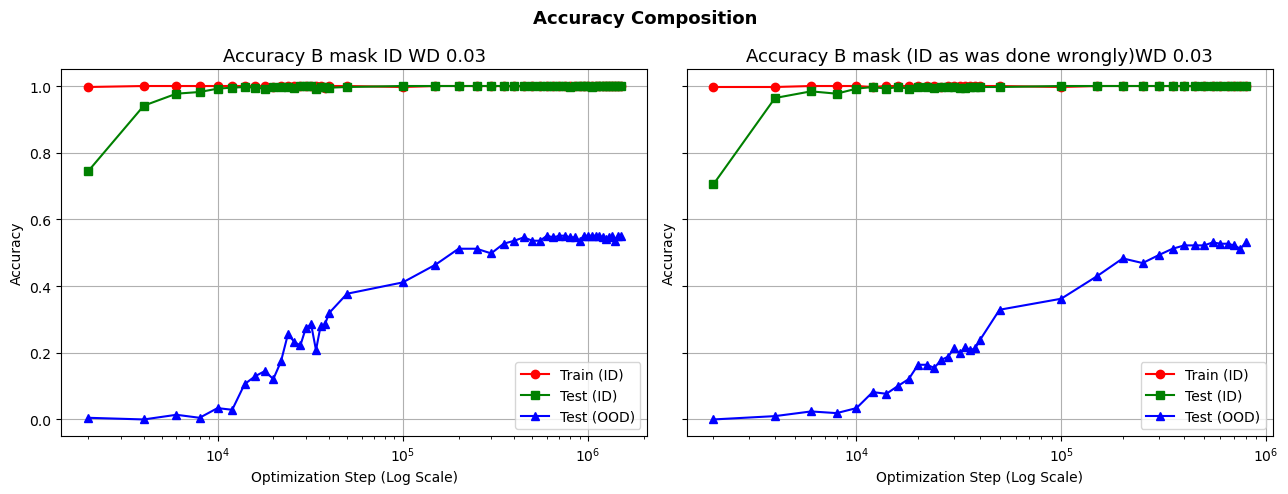

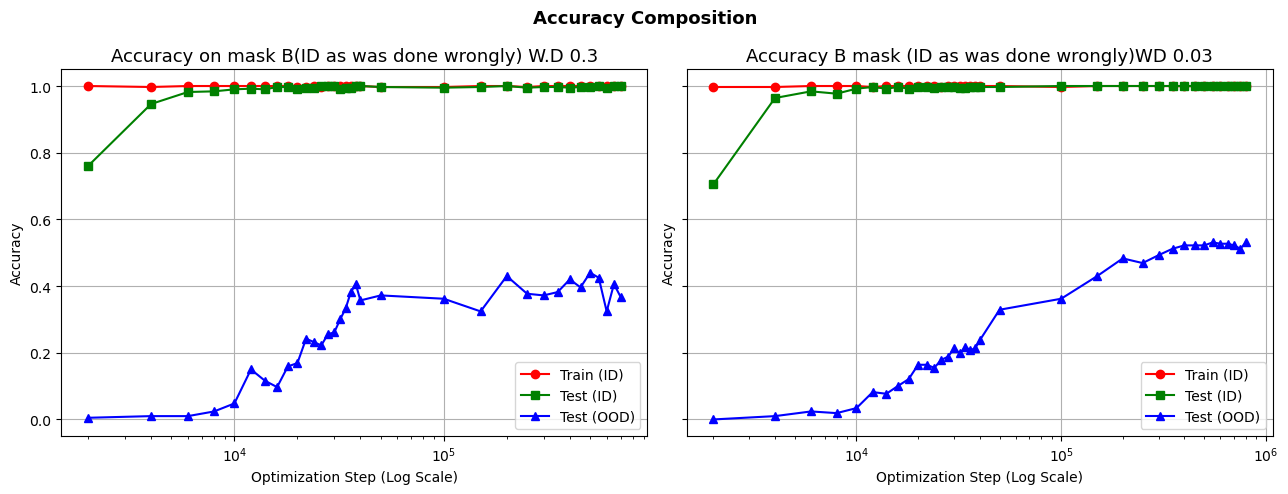

100%|██████████| 51/51 [00:00<00:00, 271.91it/s]


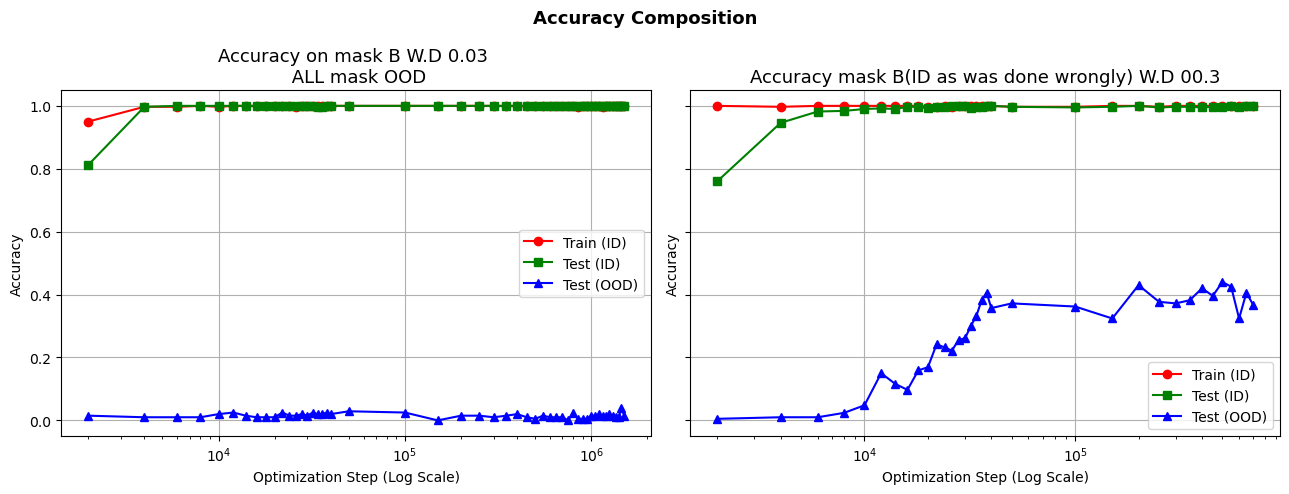

In [22]:
#  Test DATA _MIO

 #"/dtu-compute/s220331/composition/model_paper/outputs_sharing_2000_200_12_6/"
#  ID CASE ,WD 0.03
#ID_mask_B ="/scratch/davide/model_paper/correct_ID_mask_B_0_WD_0_03/"
ID_mask_B = "/dtu-compute/s220331/composition/model_paper/correct_ID_mask_B_0_WD_0_03/"

dic_mask_ID_mask_B= dic_scores(ID_mask_B, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')


#NORMAL OOD case from  here
#wd 0.3
#mask_B ="/scratch/davide/model_paper/mask_B_0_WD_0_3/"
mask_B ="/scratch/davide/model_paper/mask_B_0_WD_0_3_new/" # new with corrected datset
mask_B ="/dtu-compute/s220331/composition/model_paper/mask_B_0_WD_0_3_new/" # new with corrected datset
dic_mask_mask_B= dic_scores(mask_B, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

# WD 0.03
mask_B_WD_0_03="/scratch/davide/model_paper/mask_B_0_WD_0_03/"
mask_B_WD_0_03="/dtu-compute/s220331/composition/model_paper/mask_B_0_WD_0_03/"
dic_mask_mask_B_WD_0_03= dic_scores(mask_B_WD_0_03, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')


Acc_graph(dic_mask_ID_mask_B, dic_mask_mask_B_WD_0_03 ,title_1 = 'Accuracy B mask ID WD 0.03'  , title_2 = "Accuracy B mask (ID as was done wrongly)WD 0.03",compare_scale=False)
#Loss_graph_1(mask_mask , mask_B,title_1 = 'Loss on Complete Data, 1.5 million steps'  , title_2 = "Loss on Complete Data, 50k steps")
Acc_graph(dic_mask_mask_B, dic_mask_mask_B_WD_0_03 ,title_1 = 'Accuracy on mask B(ID as was done wrongly) W.D 0.3'  , title_2 = "Accuracy B mask (ID as was done wrongly)WD 0.03",compare_scale=False)

# This should generalize the OOD much faster (in term or getting to 100%accuracy faster similar to phi augmentation)
all_OOD_mask_B_WD_0_03="/scratch/davide/model_paper/mask_B_0_WD_0_03_ALL_OOD"
all_OOD_dic_mask_mask_B_WD_0_03= dic_scores(all_OOD_mask_B_WD_0_03, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')
Acc_graph(all_OOD_dic_mask_mask_B_WD_0_03, dic_mask_mask_B ,title_1 = 'Accuracy on mask B W.D 0.03 \n ALL mask OOD'  , title_2 = "Accuracy mask B(ID as was done wrongly) W.D 00.3",compare_scale=False)

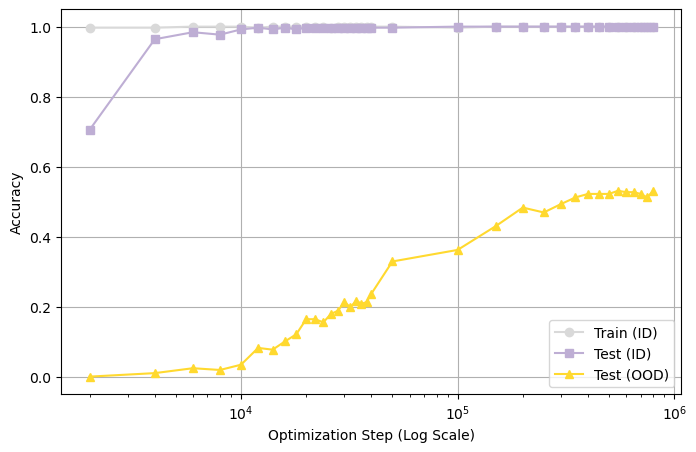

In [23]:
Acc_1(dic_mask_mask_B_WD_0_03)

# MASK B correct

the OOD is correct . Before the OOD was = at ID.
Then here the augment the mask OOD to help the model

**ID with ALL the OOD in second hop manually added**
**normal mask_B with 2 times the OOD in second(some)**

100%|██████████| 51/51 [00:01<00:00, 39.05it/s]


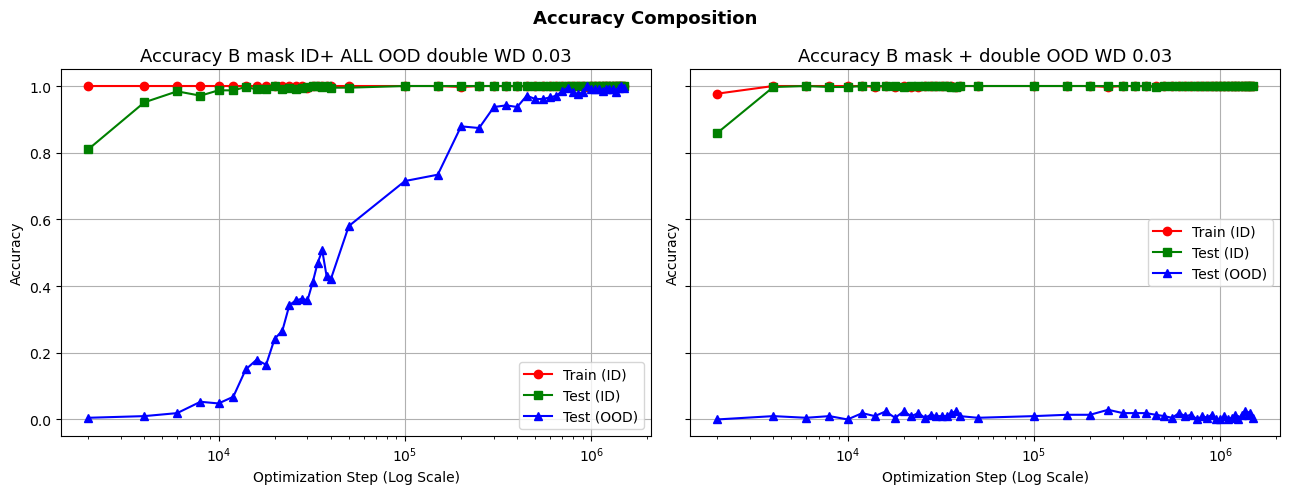

100%|██████████| 51/51 [00:01<00:00, 43.13it/s]


In [24]:
#ID_mask_B_ALL_OOD ="/scratch/davide/model_paper/ALL_OOD_ID_mask_B_0_WD_0_03/"  # double + all ood
ID_mask_B_ALL_OOD ="/dtu-compute/s220331/composition/model_paper/ALL_OOD_ID_mask_B_0_WD_0_03/"  # double + all ood
dic_mask_ID_mask_B_ALL_OOD= dic_scores(ID_mask_B_ALL_OOD, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')


#NORMAL OOD case from  here
#wd 0.3
#mask_B ="/scratch/davide/model_paper/mask_B_0_WD_0_3/"
#mask_B_some_OOD ="/scratch/davide/model_paper/mask_B_0_WD_0_03_double_some_OOD/" # new with corrected datset
mask_B_some_OOD ="/dtu-compute/s220331/composition/model_paper/mask_B_0_WD_0_03_double_some_OOD/" # new with corrected datset
dic_mask_mask_B_some_OOD= dic_scores(mask_B_some_OOD, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')




Acc_graph(dic_mask_ID_mask_B_ALL_OOD, dic_mask_mask_B_some_OOD ,title_1 = 'Accuracy B mask ID+ ALL OOD double WD 0.03'  , title_2 = "Accuracy B mask + double OOD WD 0.03",compare_scale=False)


#### some ID (400) and all OOD double (actually All ood once and some OOD double)
#mask_B_ALL_OOD_some_ID= "/scratch/davide/model_paper/ALL_OOD_SOME_ID_mask_B_0_WD_0_03/"
mask_B_ALL_OOD_some_ID= "/dtu-compute/s220331/composition/model_paper/ALL_OOD_SOME_ID_mask_B_0_WD_0_03/"
dic_mask_B_ALL_OOD_some_ID= dic_scores(mask_B_ALL_OOD_some_ID, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')



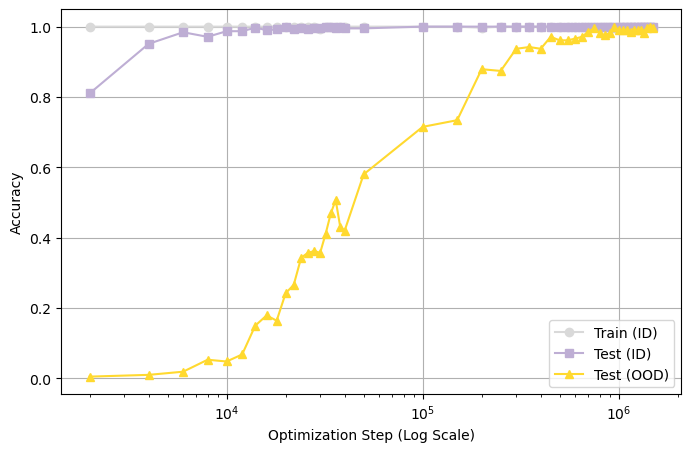

In [25]:
Acc_1(dic_mask_ID_mask_B_ALL_OOD)

# 23 K

 here letm test if with putting enhough mask:B_OOD (23K on a total of train inferred of 50k) it will generalize. As ven if we put all the mask_B_ood it do not geenralize without the mask_B_ ID. But not sure if is beacase he need to see the "connection" from ID inferred to mask ID and  to mask OOD or is just beacuse the training with maks ID has like 23 K mask_B and 23 inferred normal. Instead by just using normal mask_B_OOD the train has 200 or 400 mask and 50 K inferred normal. So like not taking much in consideration the mask.

100%|██████████| 51/51 [00:01<00:00, 38.90it/s]


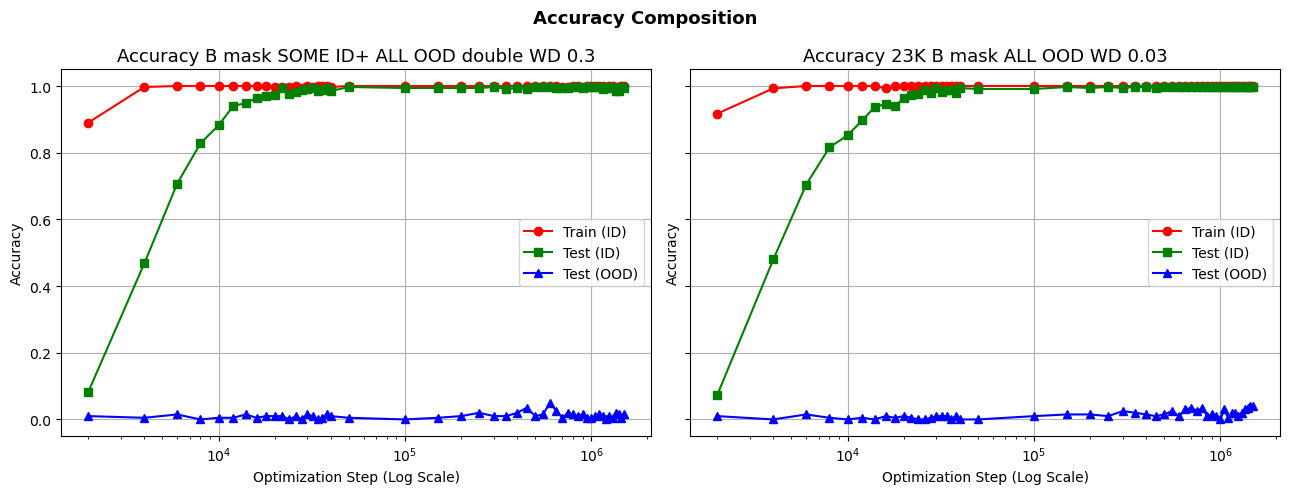

In [26]:

mask_B_ALL_OOD_23K= "/dtu-compute/s220331/composition/model_paper/23K_mask_B_ONLY_OOD_WD_0_03"
dic_mask_B_ALL_OOD_23K= dic_scores(mask_B_ALL_OOD_23K, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

mask_B_ALL_OOD_23K_WD_0_3 = "/dtu-compute/s220331/composition/model_paper/23K_mask_B_ONLY_OOD_WD_0_3_new" #"/dtu-compute/s220331/composition/model_paper/23K_mask_B_ONLY_OOD_WD_0_3"
dic_mask_B_ALL_OOD_23K_WD_0_3= dic_scores(mask_B_ALL_OOD_23K_WD_0_3, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')


Acc_graph(dic_mask_B_ALL_OOD_23K_WD_0_3, dic_mask_B_ALL_OOD_23K ,title_1 = 'Accuracy B mask SOME ID+ ALL OOD double WD 0.3'  , title_2 = "Accuracy 23K B mask ALL OOD WD 0.03",compare_scale=False)

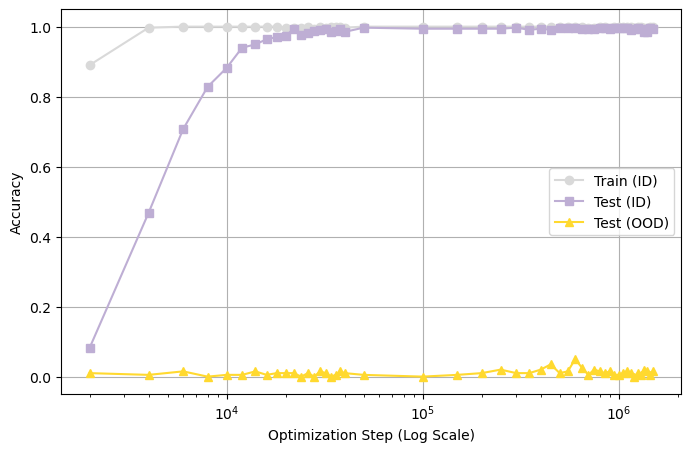

In [27]:
Acc_1(dic_mask_B_ALL_OOD_23K_WD_0_3)

From the ID all OOD double we can see that the model learn the OOD just by seeing it in the second hop, withot the need to train it on "right connections". We just "allow" the model to use it in the second position. But what is interesting to notice that the dataset were the mask ID are not present even with double OOD (even if not complete in this case) is not able to generalize. 

**Reasons to check:**
1) The ID works due to a consistent presence of (mask-atomic)
    ID actually has almost half of the training with also mask ID (so the mask, atomic is really present in the train like 20k from 50k) instead it the only OOD the 400 units on 50k
2) The ID works only bc it connect the gap between ID and OOD. Teaching the model that actually the ID and OOD should be trsited the same.

# NO 2 HOP /some hop case
**problem:** The train datsets are much smaller!

In this section we tried to modify the dataset in the following way:

1) **No 2 HOP**: The train set consist only by all Atomic facts seen in first and second position (base atomic set up and "mask/placeholder-atomic" set up. In other words the normal inferred facts are beeing replaced by the 'mask-atomic' for both ID and OOD.

2)**NO 2HOP with some**: In this case we added some normal ID inferred facts (~ 400). 

  0%|          | 0/51 [00:00<?, ?it/s]

100%|██████████| 51/51 [00:00<00:00, 283.15it/s]


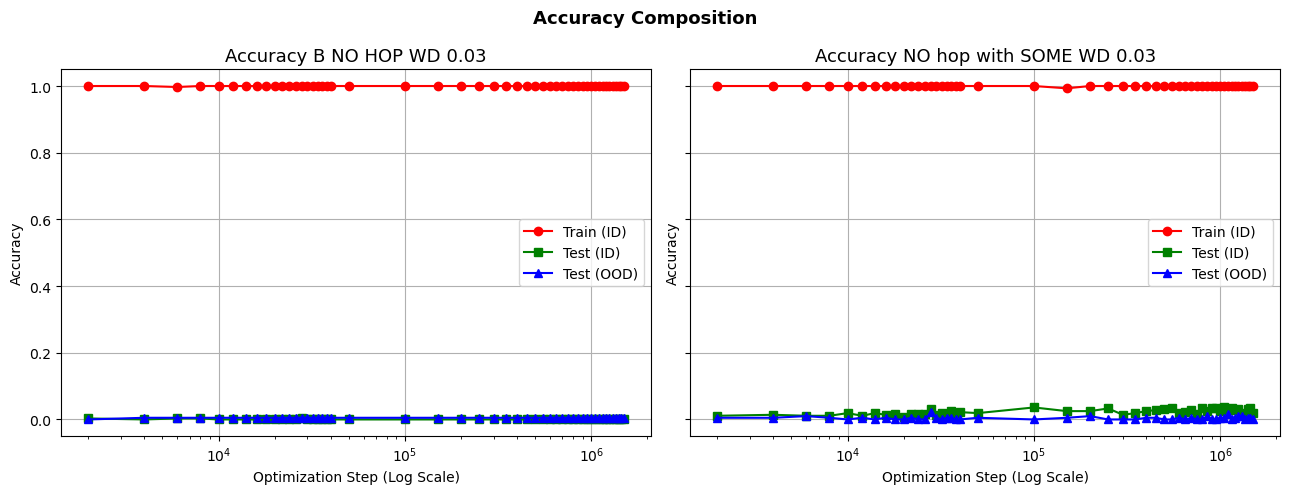

In [28]:
#no_hop_some="/scratch/davide/model_paper/no_2_hop_SOME/"
no_hop_some="/dtu-compute/s220331/composition/model_paper/no_2_hop_SOME/"

dic_no_hop_SOME= dic_scores(no_hop_some, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

no_hop="/scratch/davide/model_paper/no_2_hop/"
dic_no_hop= dic_scores(no_hop, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

Acc_graph(dic_no_hop , dic_no_hop_SOME ,title_1 = 'Accuracy B NO HOP WD 0.03'  , title_2 = "Accuracy NO hop with SOME WD 0.03",compare_scale=False)

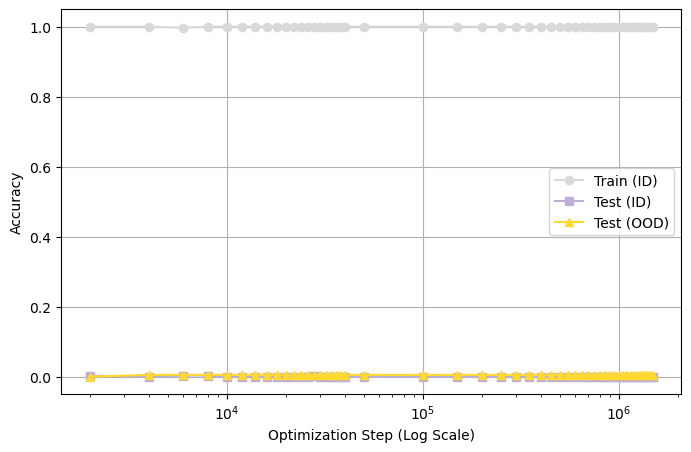

In [29]:
Acc_1(dic_no_hop)

# FINAL BIG_ mask

  0%|          | 0/46 [00:00<?, ?it/s]

100%|██████████| 51/51 [00:06<00:00,  7.51it/s]


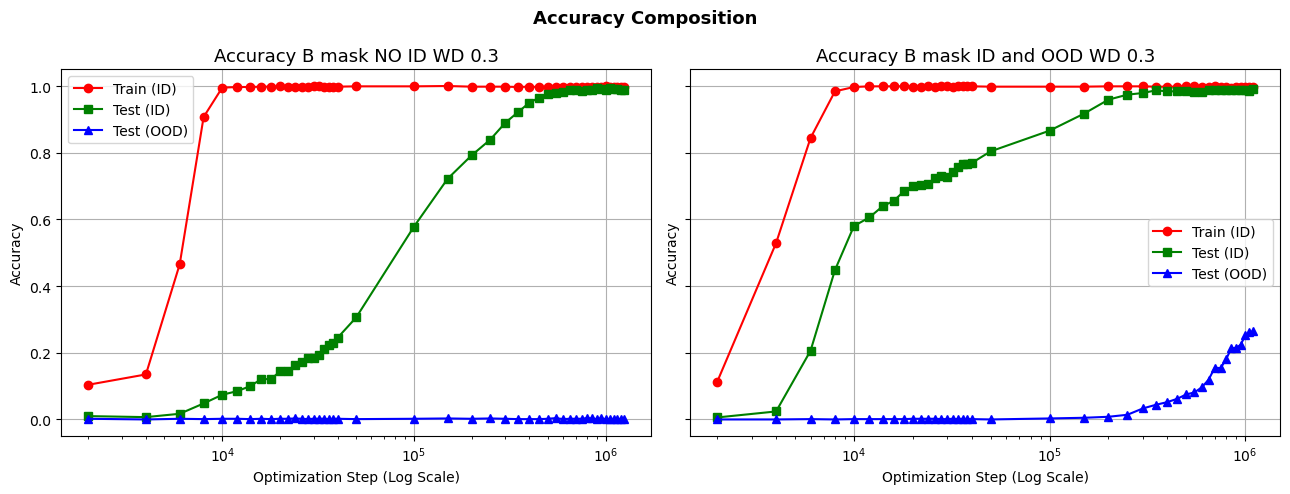

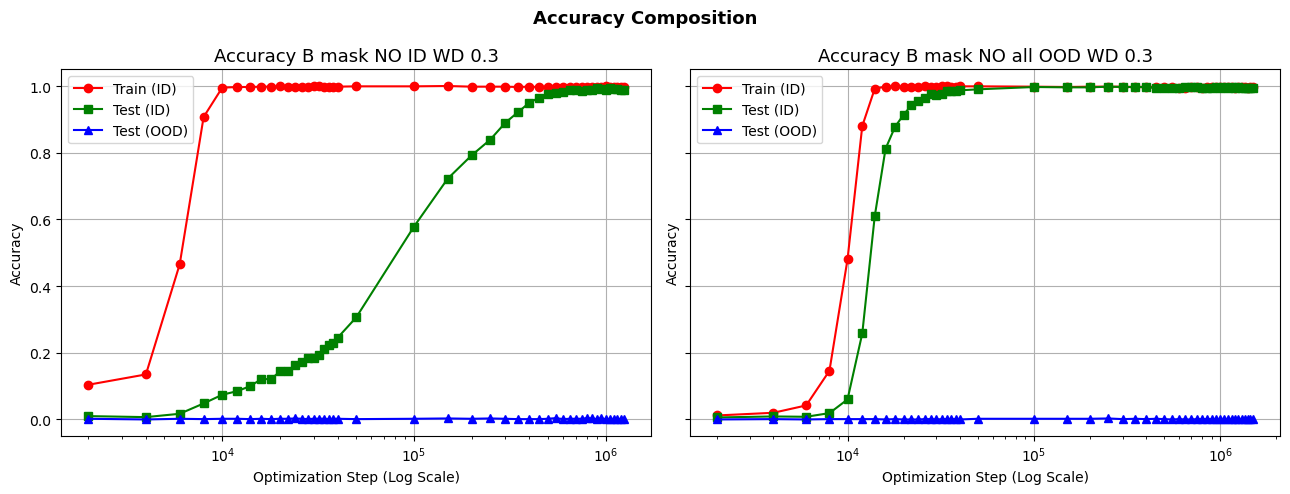

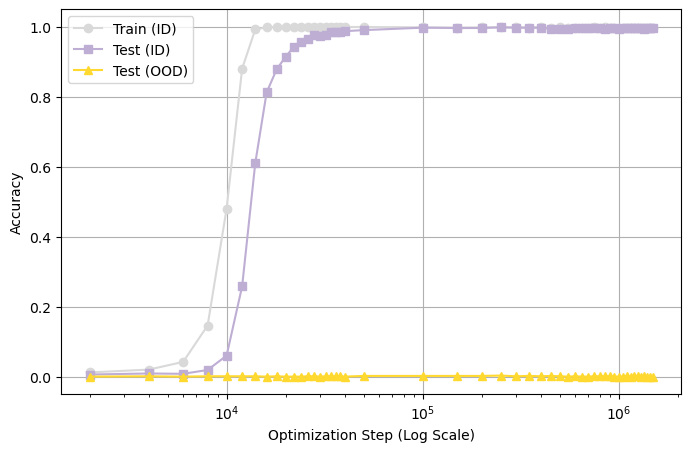

In [30]:
big_mask_NO_ID= "/dtu-compute/s220331/composition/model_paper/BIG_23K_mask_B_ONLY_OOD_WD_0_3"  # no ID
dic_big_mask_NO_ID= dic_scores(big_mask_NO_ID, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')


big_mask_ID_and_OOD= "/dtu-compute/s220331/composition/model_paper/BIG_mask_b_ID_and_OOD"  # ID and OOD =the final generlaizatio (ex_1)
dic_big_mask_ID_and_OOD= dic_scores(big_mask_ID_and_OOD, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

#no all OOD ="ratio"
big_mask_NO_all_OOD= "/dtu-compute/s220331/composition/model_paper/BIG_mask_no_all_OOD"
dic_big_mask_NO_all_OOD= dic_scores(big_mask_NO_all_OOD, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

Acc_graph(dic_big_mask_NO_ID , dic_big_mask_ID_and_OOD ,title_1 = 'Accuracy B mask NO ID WD 0.3'  , title_2 = "Accuracy B mask ID and OOD WD 0.3",compare_scale=False)
Acc_graph(dic_big_mask_NO_ID , dic_big_mask_NO_all_OOD ,title_1 = 'Accuracy B mask NO ID WD 0.3'  , title_2 = "Accuracy B mask NO all OOD WD 0.3",compare_scale=False)

Acc_1( dic_big_mask_NO_all_OOD )

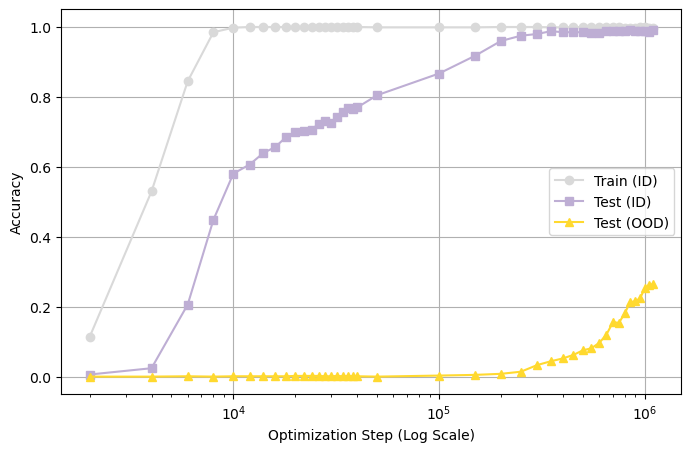

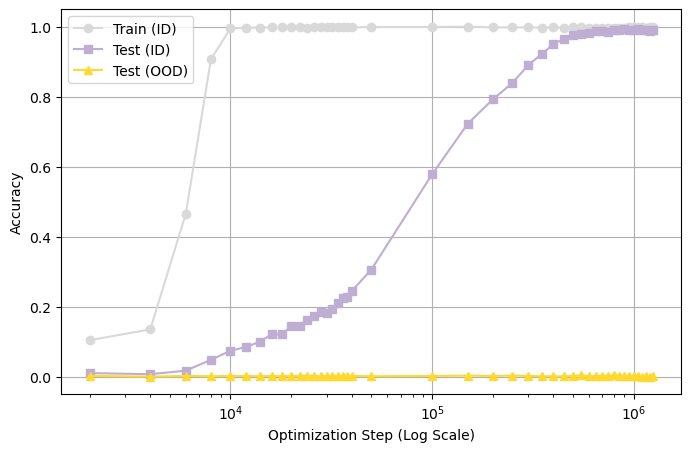

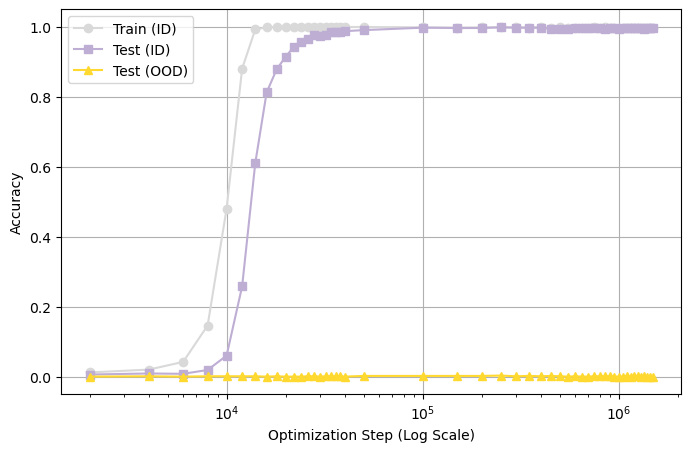

In [31]:
Acc_1(dic_big_mask_ID_and_OOD)
Acc_1(dic_big_mask_NO_ID )
Acc_1( dic_big_mask_NO_all_OOD )

  0%|          | 0/55 [00:00<?, ?it/s]

100%|██████████| 66/66 [00:02<00:00, 27.62it/s]


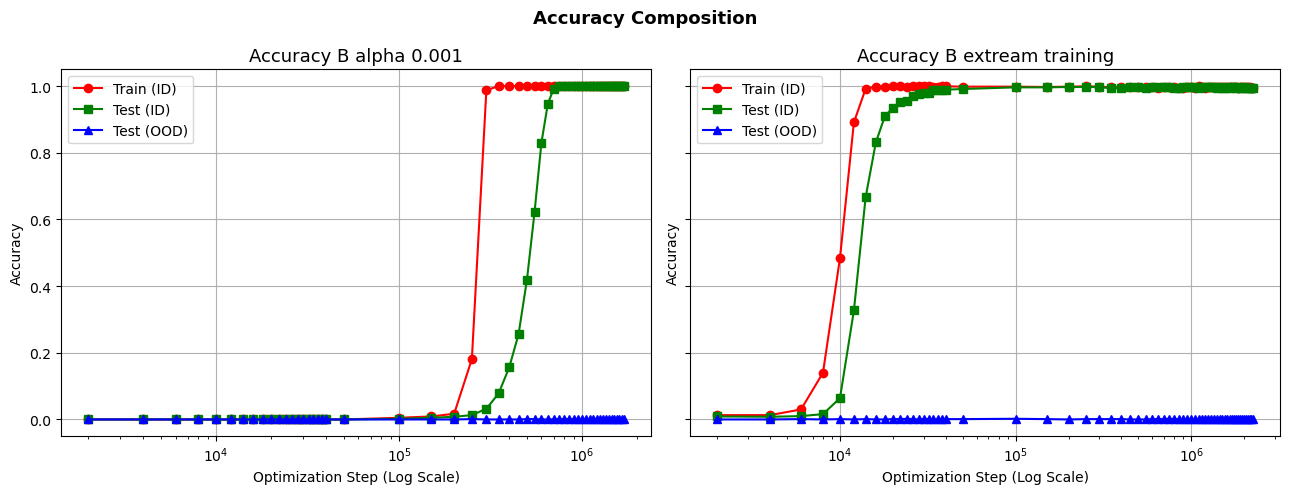

In [32]:
big_extream_train_alpha ="/dtu-compute/s220331/composition/outputs_BIG_alpha_0_001/"
dic_big_extream_train_alpha = dic_scores(big_extream_train_alpha, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

big_extream_train= "/dtu-compute/s220331/composition/outputs_BIG_extream_training/"
dic_big_extream_train = dic_scores(big_extream_train, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

Acc_graph(dic_big_extream_train_alpha , dic_big_extream_train ,title_1 = 'Accuracy B alpha 0.001'  , title_2 = "Accuracy B extream training",compare_scale=False)




#  Test DATA _MIO

100%|██████████| 51/51 [00:00<00:00, 261.91it/s]


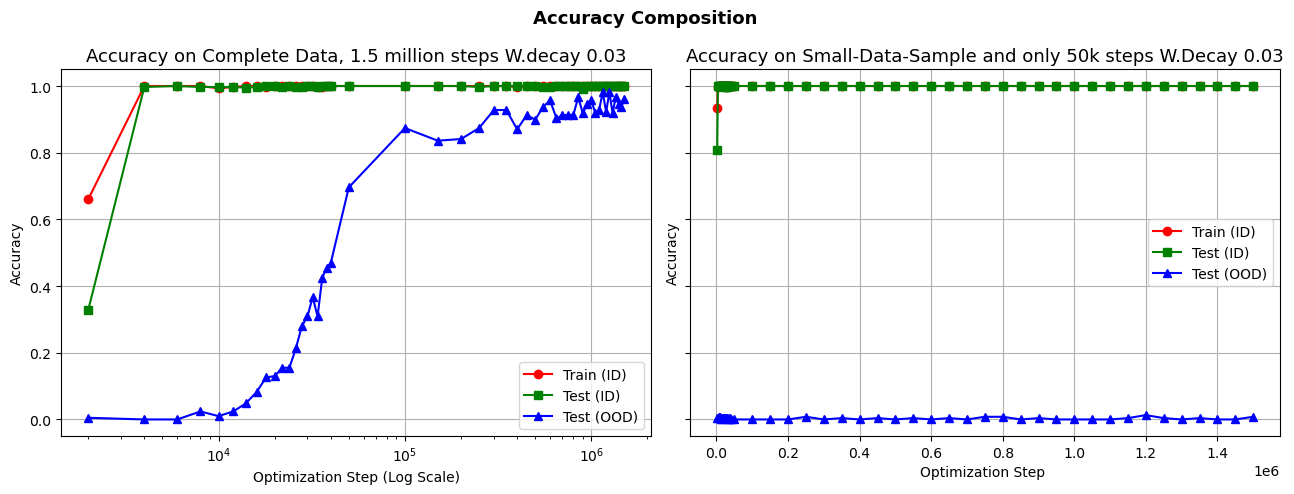

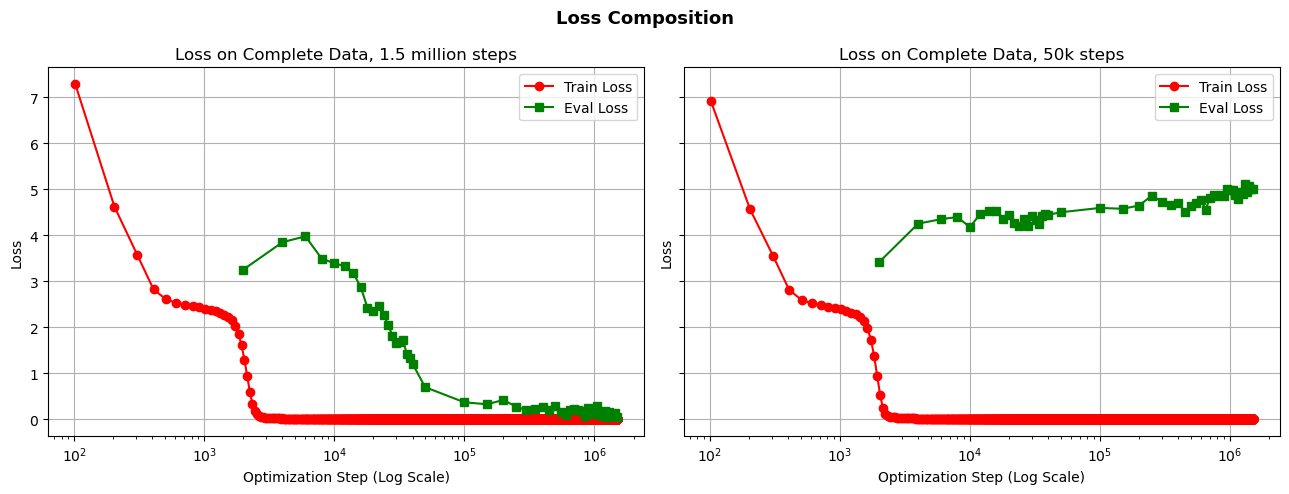

In [33]:
#  Test DATA _MIO
#/scratch/davide/model_paper/test_DATA_MIO_normale/
t= "/dtu-compute/s220331/composition/re_embed_sharing/" #"/scratch/davide/model_paper/test_DATA_MIO_normale/"

dic_t= dic_scores(t, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

Acc_graph(dic_t , dic_score_SMALL ,title_1 = 'Accuracy on Complete Data, 1.5 million steps W.decay 0.03'  , title_2 = "Accuracy on Small-Data-Sample and only 50k steps W.Decay 0.03",compare_scale=True)
Loss_graph_1(t , SMALL,title_1 = 'Loss on Complete Data, 1.5 million steps'  , title_2 = "Loss on Complete Data, 50k steps")

** Below the check of the dataset mask_B . It was wrongly set up = at the mask_ ID.

In [34]:
import json

# Path to the JSON file
file_path = '/home/s220331/GROK/Thesis/data_MIO_mask_NEW/ID_mask_B_composition.200.20.12.6/train.json'

# Read the JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

# Determine the length of the list
list_length = len(data)
# Count the occurrences of <mask> in input_text
mask_count = sum(item["input_text"].count("<mask>") for item in data)

print(f"The tag <mask> appears {mask_count} times in the input text.")

print(f"The length of the list in the JSON file is {list_length}.")

FileNotFoundError: [Errno 2] No such file or directory: '/home/s220331/GROK/Thesis/data_MIO_mask_NEW/ID_mask_B_composition.200.20.12.6/train.json'

In [ ]:
import json

# Path to the JSON file
file_path_1 = '/home/s220331/GROK/Thesis/data_MIO_mask_NEW/mask_B_composition.200.20.12.6/train.json'

# Read the JSON file
with open(file_path_1, 'r') as file_1:
    data_1 = json.load(file_1)

# Determine the length of the list
list_length_1 = len(data_1)
# Count the occurrences of <mask> in input_text
mask_count = sum(item["input_text"].count("<mask>") for item in data_1)

print(f"The tag <mask> appears {mask_count} times in the input text.")
print(file_path_1)
print(f"The length of the list in the JSON file is {list_length_1}.")

The tag <mask> appears 23877 times in the input text.
/home/s220331/GROK/Thesis/data_MIO_mask_NEW/mask_B_composition.200.20.12.6/train.json
The length of the list in the JSON file is 51880.


In [ ]:
#/home/s220331/GROK/Thesis/data_MIO_mask_NEW/composition.200.20.12.6/train.json


import json

# Path to the JSON file
file_path_2 = '/home/s220331/GROK/Thesis/data_MIO_mask_NEW/composition.200.20.12.6/train.json'

# Read the JSON file
with open(file_path_2, 'r') as file_2:
    data_2 = json.load(file_2)

# Determine the length of the list
list_length_2 = len(data_2)
# Count the occurrences of <mask> in input_text
mask_count = sum(item["input_text"].count("<mask>") for item in data_2)

print(f"The tag <mask> appears {mask_count} times in the input text.")

print(f"The length of the list in the JSON file is {list_length_2}.")

The tag <mask> appears 0 times in the input text.
The length of the list in the JSON file is 51880.


In [ ]:
# check that ID masb-B all OOD has no mask in test!
import json

# Define the path to the JSON file
file_path = '/home/s220331/GROK/Thesis/data_MIO_mask_NEW_correct/ID_mask_B_composition_ALL_OOD.200.20.12.6/test.json'

# Load the JSON data from the file
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract entries with type 'train_inferred' that contain '<mask>'
train_inferred_with_mask = [entry for entry in data if entry['type'] == 'train_inferred' and '<mask>' in entry['input_text']]
OOD_train_inferred_with_mask = [entry for entry in data if entry['type'] == "test_inferred_ood" and '<mask>' in entry['input_text']]
# Print the extracted entries
print("mask in train",len(train_inferred_with_mask))
print("mask in TEST OOD should be null:",len(OOD_train_inferred_with_mask))

mask in train 146
mask in TEST OOD should be null: 0


In [ ]:
"test_inferred_ood"

'test_inferred_ood'

# COMPARISON

100%|██████████| 51/51 [00:08<00:00,  5.68it/s]


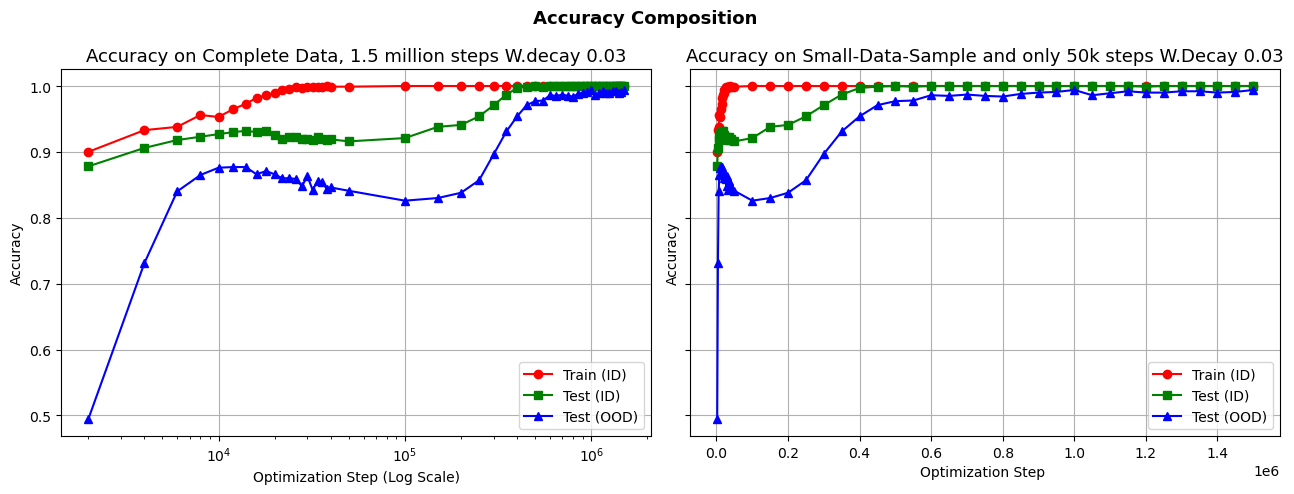

In [ ]:
comparison ="/dtu-compute/s220331/COMPARISON/comparison.1000.12.6"

dic_comparison= dic_scores(comparison, check = False, fn = 'all_items.json',file_name = 'Accuracy_Loss.ipynb')

Acc_graph(dic_comparison , dic_comparison ,title_1 = 'Accuracy on Complete Data, 1.5 million steps W.decay 0.03'  , title_2 = "Accuracy on Small-Data-Sample and only 50k steps W.Decay 0.03",compare_scale=True)

In [6]:
import matplotlib.pyplot as plt
#import seaborn as sns

def Acc_1(data, log=True):
    optimization_steps = [int(checkpoint.split('-')[1]) for checkpoint, _ in data]
    train_id = [dict(results)['train_inferred'] for _, results in data]  
    test_id = [dict(results)['test_inferred_iid'] for _, results in data]
    test_ood = [dict(results)['test_inferred_ood'] for _, results in data]

    # Use Accent colormap
    accent_colors = plt.get_cmap("Accent").colors

    set3_cmap = plt.get_cmap("Set3")
    set1_cmap = plt.get_cmap("Set2")
    train_color = set3_cmap(8) #'#A9A9A9' #'#A9A9A9' #accent_colors[6]  # Soft Gray
    test_id_color =  accent_colors[1] #set3_cmap(2) #accent_colors[3]  # Violet
    test_ood_color = set1_cmap(5)# set3_cmap(11) #set1_cmap(5) #"#E41A1C" #'#FFD700' #accent_colors[1]  # Yellow

    # Create the figure
    plt.figure(figsize=(8, 5))

    # Plot the data with Accent colormap colors
    plt.plot(optimization_steps, train_id, 'o-', label='Train (ID)', color=train_color)
    plt.plot(optimization_steps, test_id, 's-', label='Test (ID)', color=test_id_color)
    plt.plot(optimization_steps, test_ood, '^-', label='Test (OOD)', color=test_ood_color)

    # Labels and title
    plt.ylabel('Accuracy')
    plt.xlabel('Optimization Step (Log Scale)' if log else 'Optimization Step')
    #plt.title('Accuracy Composition', fontsize=13, fontweight='bold')

    # Set log scale if required
    if log:
        plt.xscale('log')

    # Legend and grid
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()


In [7]:
Acc_1(dic_comparison)

NameError: name 'dic_comparison' is not defined